In [1]:
# Native libraries
import os
import math

# Essential Libraries
import plotly.graph_objects as go
import plotly.express as px

# Other libraries
import ast
import json
import csv
import io
import gzip

# Datetime 
import datetime as dt
import datetime
from datetime import date, timedelta

# model
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, log_loss, confusion_matrix
import statsmodels.stats.proportion as smp
from scipy import stats
import xgboost as xgb

/h/jennyyu/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/h/jennyyu/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
df_birth = pd.read_csv(r'/storage/data/bump/bump/redcap/birthing_data.csv.gz')
df_birth['date'] = pd.to_datetime(df_birth.birth_date).dt.date

def findDaysSince(df):
    """
    Takes a provided dataframe and adds a new column for days since delivery if a delivery date is provided

    :param df: dataframe
    :return: dataframe with new column "daysSince"
    """
    df2 = []
   
    # for every unique user
    for record_id in df.record_id.unique():
        
        if (len(df_birth.loc[df_birth.record_id == record_id]) != 0):
            birth = df_birth.loc[df_birth.record_id == record_id].reset_index()
            birthDate = birth['date'][0]
            # If the birth date is not null
            if (pd.isnull(birthDate) == False):
                # Get individual dataframe
                userDF = df[df['record_id'] == record_id]
                # For every date in the dataframe, add a new column value for days since birth
                userDF['daysSince'] = userDF.apply(lambda row: row.date - birthDate, axis=1)
                df2.append(userDF)
    return pd.concat(df2, ignore_index=True)

def findGestationalAge(df):
    df2 = []
   
    # for every unique user
    for record_id in df.record_id.unique():
        
        if (len(df_birth.loc[df_birth.record_id == record_id]) != 0):
            birth = df_birth.loc[df_birth.record_id == record_id].reset_index()
            birthDate = birth['conception'][0]
            # If the birth date is not null
            if (pd.isnull(birthDate) == False):
                # Get individual dataframe
                userDF = df[df['record_id'] == record_id]
                # For every date in the dataframe, add a new column value for days since birth
                userDF['daysSince'] = userDF.apply(lambda row: row.date - birthDate, axis=1)
                df2.append(userDF)
    return pd.concat(df2, ignore_index=True)

def findRecordID(users):
    """
    Takes a list of user ids and returns a list of record ids

    :param users: list of user ids
    :return: list of record ids
    """
    record_ids = []
    for item in users:
        participant = df_studyID[df_studyID.user_id == item]
        record = participant.iloc[0]['record_id']
        record_ids.append(record)
    return record_ids
# Calculate the conception date for each participant that has delivered
def subtract_duration(input_str, date_variable):
    # Remove any non-numeric characters from the input string
    if pd.isna(input_str):
        # print('Invalid input format')
        return ''

    input_str = ''.join(filter(str.isdigit, input_str))

    # Convert the input string to integers
    try:
        weeks = 0
        days = 0
        if len(input_str) > 3:
            # print('Invalid input format')
            return ''
        if len(input_str) == 3:
            weeks = int(input_str[:-1])
            days = int(input_str[-1:])
        if len(input_str) == 2:
            weeks = int(input_str)
            days = 0
    except ValueError:
        raise ValueError("Invalid input format")
    # Calculate the total number of days in the duration

    total_days = (weeks * 7) + days
    # print(total_days)
    
    # Create a timedelta object for the duration
    duration = timedelta(days=total_days)
    
    # Subtract the duration from the datetime variable
    result_date = date_variable - duration
    
    return result_date

def duration(input_str, date_variable):
    # Remove any non-numeric characters from the input string
    if pd.isna(input_str):
        # print('Invalid input format')
        return ''

    input_str = ''.join(filter(str.isdigit, input_str))

    # Convert the input string to integers
    try:
        weeks = 0
        days = 0
        if len(input_str) > 3:
            # print('Invalid input format')
            return ''
        if len(input_str) == 3:
            weeks = int(input_str[:-1])
            days = int(input_str[-1:])
        if len(input_str) == 2:
            weeks = int(input_str)
            days = 0
    except ValueError:
        raise ValueError("Invalid input format")
    # Calculate the total number of days in the duration
    total_days = (weeks * 7) + days
    
    # Create a timedelta object for the duration
    duration = timedelta(days=total_days)

    return duration


df_birth['conception'] = df_birth.apply(lambda x: subtract_duration(x['birth_gestage'], x['date']), axis=1)
df_birth['conception'] = pd.to_datetime(df_birth.conception).dt.date
# df_birth['duration'] = df_birth.apply(lambda x: duration(x['birth_gestage'], x['date']), axis=1)

## Self-reported daily survey

In [3]:
# bump-c surveys
# Daily Survey: (7-point scale where 1="none" and 7="severe")
# 'fatigue': 986

df_survey_bump_c = pd.read_csv(r'/storage/data/bump/bump-c/app_activities/surveys.csv.gz')
df_fatigue_bump_c = df_survey_bump_c[df_survey_bump_c['question_id'] == 986]
df_fatigue_bump_c['event_date'] = pd.to_datetime(df_fatigue_bump_c.event_date, errors='coerce').dt.date
df_fatigue_bump_c['answer_text'] = df_fatigue_bump_c['answer_text'].astype(int)
df_fatigue_bump_c['fatigue_boolean'] = df_fatigue_bump_c['answer_text'].apply(lambda x: 1 if x > 3 else 0)

/tmp/ipykernel_4040/822994797.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fatigue_bump_c['event_date'] = pd.to_datetime(df_fatigue_bump_c.event_date, errors='coerce').dt.date
/tmp/ipykernel_4040/822994797.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fatigue_bump_c['answer_text'] = df_fatigue_bump_c['answer_text'].astype(int)
/tmp/ipykernel_4040/822994797.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [4]:
# Daily Survey: (7-point scale where 1="none" and 7="severe")
# 'nausea': 203
# 'fatigue': 204
# 'mood': 205

df_survey_bump = pd.read_csv(r'/storage/data/bump/bump/app_activities/surveys.csv.gz')
df_fatigue_bump = df_survey_bump[df_survey_bump['question_id'] == 204]
df_fatigue_bump['event_date'] = pd.to_datetime(df_fatigue_bump.event_date, errors='coerce').dt.date
df_fatigue_bump['answer_text'] = df_fatigue_bump['answer_text'].astype(int)
df_fatigue_bump['fatigue_boolean'] = df_fatigue_bump['answer_text'].apply(lambda x: 1 if x > 3 else 0)

/tmp/ipykernel_4040/2507425610.py:6: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_survey_bump = pd.read_csv(r'/storage/data/bump/bump/app_activities/surveys.csv.gz')
/tmp/ipykernel_4040/2507425610.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fatigue_bump['event_date'] = pd.to_datetime(df_fatigue_bump.event_date, errors='coerce').dt.date
/tmp/ipykernel_4040/2507425610.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fatigue_bump['an

In [5]:
df_fatigue = pd.concat([df_fatigue_bump, df_fatigue_bump_c], axis=0, ignore_index=True)
merged_df = pd.merge(df_fatigue[['user_id', 'event_date', 'fatigue_boolean', 'answer_text']], df_birth[['user_id', 'birth_date', 'conception']], on='user_id', how='inner')
merged_df['conception'] = pd.to_datetime(merged_df['conception'])
merged_df['event_date'] = pd.to_datetime(merged_df['event_date'])
merged_df['gest_age'] = (merged_df['event_date'] - merged_df['conception']).dt.days
merged_df = merged_df.dropna()
merged_df['gest_week'] = merged_df['gest_age']//7
merged_df = merged_df[(merged_df['gest_week']>=1) & (merged_df['gest_week']<=41)]

In [6]:
# Aggregate data by gestational week
all_users_has_fatigue = merged_df[merged_df['fatigue_boolean'] == 1].groupby('gest_week')['user_id'].nunique().reset_index()
all_users = merged_df.groupby('gest_week')['user_id'].nunique().reset_index()
all_users_weekly_fatigue = all_users.merge(all_users_has_fatigue, on='gest_week', how='left', suffixes=('_count_all', '_count_positive'))
all_users_weekly_fatigue['occurrence'] = all_users_weekly_fatigue['user_id_count_positive'] / all_users_weekly_fatigue['user_id_count_all']

# Calculate the Agresti-Coull confidence interval
all_users_lower_bounds, all_users_upper_bounds = smp.proportion_confint(all_users_weekly_fatigue['user_id_count_positive'].tolist(), all_users_weekly_fatigue['user_id_count_all'].tolist(), alpha=0.05, method='agresti_coull')

### E: Only users tracking on a single day

In [7]:
# Group by user_id and count unique event_dates
user_event_counts = merged_df.groupby('user_id')['event_date'].nunique()

# Filter user_ids with at least two different event_dates
users_with_min_1_dates = user_event_counts[user_event_counts >= 1].index

# Extract rows with these user_ids
merged_df_min_1_dates = merged_df[merged_df['user_id'].isin(users_with_min_1_dates)]

In [8]:
# Aggregate data by gestational week
min_1_dates_has_fatigue = merged_df_min_1_dates[merged_df_min_1_dates['fatigue_boolean'] == 1].groupby('gest_week')['user_id'].nunique().reset_index()
min_1_dates_users = merged_df_min_1_dates.groupby('gest_week')['user_id'].nunique().reset_index()
min_1_dates_weekly_fatigue = min_1_dates_users.merge(min_1_dates_has_fatigue, on='gest_week', how='left', suffixes=('_count_all', '_count_positive'))
min_1_dates_weekly_fatigue['occurrence'] = min_1_dates_weekly_fatigue['user_id_count_positive'] / min_1_dates_weekly_fatigue['user_id_count_all']

# Calculate the Agresti-Coull confidence interval
min_1_dates_lower_bounds, min_1_dates_upper_bounds = smp.proportion_confint(min_1_dates_weekly_fatigue['user_id_count_positive'].tolist(), min_1_dates_weekly_fatigue['user_id_count_all'].tolist(), alpha=0.05, method='agresti_coull')


### G: Only users tracking symptoms on min. 2 diff. days


In [9]:
# Group by user_id and count unique event_dates
user_event_counts = merged_df.groupby('user_id')['event_date'].nunique()

# Filter user_ids with at least two different event_dates
users_with_min_2_dates = user_event_counts[user_event_counts >= 2].index

# Extract rows with these user_ids
merged_df_min_2_dates = merged_df[merged_df['user_id'].isin(users_with_min_2_dates)]

In [10]:
# Aggregate data by gestational week
min_2_dates_has_fatigue = merged_df_min_2_dates[merged_df_min_2_dates['fatigue_boolean'] == 1].groupby('gest_week')['user_id'].nunique().reset_index()
min_2_dates_users = merged_df_min_2_dates.groupby('gest_week')['user_id'].nunique().reset_index()
min_2_dates_weekly_fatigue = min_2_dates_users.merge(min_2_dates_has_fatigue, on='gest_week', how='left', suffixes=('_count_all', '_count_positive'))
min_2_dates_weekly_fatigue['occurrence'] = min_2_dates_weekly_fatigue['user_id_count_positive'] / min_2_dates_weekly_fatigue['user_id_count_all']

# Calculate the Agresti-Coull confidence interval
min_2_dates_lower_bounds, min_2_dates_upper_bounds = smp.proportion_confint(min_2_dates_weekly_fatigue['user_id_count_positive'].tolist(), min_2_dates_weekly_fatigue['user_id_count_all'].tolist(), alpha=0.05, method='agresti_coull')


### N: Only users tracking symptoms in min. 5 diff. months

In [11]:
# Extract year and month
merged_df['year_month'] = merged_df['event_date'].dt.to_period('M')

# Group by user_id and count unique year_month
user_month_counts = merged_df.groupby('user_id')['year_month'].nunique()

# Filter user_ids with at least 5 different months
users_with_min_5_months = user_month_counts[user_month_counts >= 5].index

# Extract rows with these user_ids
merged_df_min_5_months = merged_df[merged_df['user_id'].isin(users_with_min_5_months)]

In [12]:
# Aggregate data by gestational week
min_5_months_has_fatigue = merged_df_min_5_months[merged_df_min_5_months['fatigue_boolean'] == 1].groupby('gest_week')['user_id'].nunique().reset_index()
min_5_months_users = merged_df_min_5_months.groupby('gest_week')['user_id'].nunique().reset_index()
min_5_months_weekly_fatigue = min_5_months_users.merge(min_5_months_has_fatigue, on='gest_week', how='left', suffixes=('_count_all', '_count_positive'))
min_5_months_weekly_fatigue['occurrence'] = min_5_months_weekly_fatigue['user_id_count_positive'] / min_5_months_weekly_fatigue['user_id_count_all']

# Calculate the Agresti-Coull confidence interval
min_5_months_lower_bounds, min_5_months_upper_bounds = smp.proportion_confint(min_5_months_weekly_fatigue['user_id_count_positive'].tolist(), min_5_months_weekly_fatigue['user_id_count_all'].tolist(), alpha=0.05, method='agresti_coull')


## Quadratic fitting

In [13]:
df_temp = merged_df[['answer_text', 'user_id', 'gest_week']]
df_temp['gest_week'] = df_temp['gest_week'].astype('Int64')

mask = df_temp.groupby(['user_id', 'gest_week']).filter(lambda x: len(x) >= 2)
weekly_avg_df = mask.groupby(['user_id', 'gest_week']).agg({'answer_text': 'mean'}).reset_index()

import plotly.graph_objects as go
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy.signal import find_peaks

# Rank ordering of participants


# Generate a reference U-shape curve (mean across all individuals)
def generate_reference_curve(data):
    ref_curve = data.groupby('gest_week')['answer_text'].mean()
    return ref_curve

def quadratic(x, a, b, c):
    y = a*x**2 + b*x + c
    return y

r2 = []

# Count rejected participants:
lengthR = 0
vertexR = 0
min_time = 1
max_time = 40

for user in weekly_avg_df.user_id.unique():
    dfUser = weekly_avg_df[(weekly_avg_df['user_id'] == user)]
    dfUser = dfUser.sort_values('gest_week')
    dfUser = dfUser[dfUser['gest_week'] <= max_time]
    dfUser = dfUser[dfUser['gest_week'] >= min_time]


    if len(dfUser) < 15:
        lengthR += 1
        continue
    x_values = np.array(dfUser.gest_week.values, dtype=float)

    y_values_raw = np.array(dfUser.answer_text.values, dtype=float)

    mask = ~np.isnan(y_values_raw) & ~np.isinf(y_values_raw)
    x_values = x_values[mask]
    y_values_raw = y_values_raw[mask]

    if len(x_values) > 2 and len(y_values_raw) > 2:
        # Fit a quadratic function to the data
        params, _ = curve_fit(quadratic, x_values, y_values_raw)

        a, b, c = params
        vertex_x = -b/(2*a)
        vertex_y = quadratic(vertex_x, a, b, c)

        if (vertex_x < min_time or vertex_x > max_time):
            vertexR += 1
            continue

        y_fitted = quadratic(x_values, *params)

        r2_value = r2_score(y_values_raw, y_fitted)

        r2.append([r2_value, user])
    else:
        lengthR += 1

print('Rejected Length - ' + str(lengthR))
print('Rejected Vertex - ' + str(vertexR))
print('Total Participants - ' + str(len(r2)))

sorted_r2 = sorted(r2, key=lambda x: x[0], reverse=True)
sorted_r2_df = pd.DataFrame(sorted_r2, columns=['r2_value', 'user_id'])

# For Graphing Individual Curves 

# Generate a reference U-shape curve (mean across all individuals)
def generate_reference_curve(data):
    ref_curve = data.groupby('gest_week')['answer_text'].mean()
    return ref_curve

def quadratic(x, a, b, c):
    y = a*x**2 + b*x + c
    return y

def fill_with_nans(x_values, y_values_raw, max_index):
    # Initialize an array with NaN values
    y_values_with_nans = np.full(max_index + 1, np.nan)
    
    # Fill in the values at the specified indices
    for i, x in enumerate(x_values):
        y_values_with_nans[int(x)-1] = y_values_raw[i]
    
    return y_values_with_nans

def closest_element(arr, target):
    closest = None
    for num in arr:
        if num >= target:
            if closest is None or num < closest:
                closest = num
    return closest
def count_greater_than(arr, threshold):
    count = 0
    for num in arr:
        if num > threshold:
            count += 1
        if count >= 2:
            return True
    return False
vertexs = []
r2_value_all = []
filtered_users = []
peaks_all = []
count = 0
all_data = []
stretch_data = []

for user in weekly_avg_df.user_id.unique():
# for user in [28]:
    dfUser = weekly_avg_df[(weekly_avg_df['user_id'] == user)]
    dfUser = dfUser.sort_values('gest_week')

    dfUser = dfUser[dfUser['gest_week'] <= max_time]
    dfUser = dfUser[dfUser['gest_week'] >= min_time]
    x_values = np.array(dfUser.gest_week.values, dtype=float)
    if len(x_values) > 2:
        y_values_raw = np.array(dfUser.answer_text.values, dtype=float)

        mask = ~np.isnan(y_values_raw) & ~np.isinf(y_values_raw)
        x_values = x_values[mask]
        y_values_raw = y_values_raw[mask]

        if len(x_values) > 2 and len(y_values_raw) > 2:
            # Fit a quadratic function to the data
            peaks, _ = find_peaks(y_values_raw)
            peaks_all.extend(peaks)
            # print("peaks: ", x_values[peaks])
            params, _ = curve_fit(quadratic, x_values, y_values_raw)

            # Extract parameters
            a, b, c = params
            vertex_x = -b/(2*a)
            vertex_y = quadratic(vertex_x, a, b, c)

            y_fitted = quadratic(x_values, *params)
            # if count_greater_than(x_values, 28):
            #     min_max_range = (y_fitted[-1] - y_fitted[np.where(x_values == closest_element(x_values, 28))]) / (x_values[-1] - x_values[np.where(x_values == closest_element(x_values, 28))])
            # stretch_data.append(min_max_range[0])
            stretch_data.append(a * 1000)
            
            r2_value = r2_score(y_values_raw, y_fitted)
            r2_value_all.append(r2_value)
            filtered_users.append(user)
            
            
            # if r2_value > 0.84:
            count += 1

            vertexs.append(vertex_x)
            new_y_values_raw = fill_with_nans(x_values, y_values_raw, max_time-1)
            all_data.append(new_y_values_raw)
            
#             # Graph the data along with the vertex
#             fig = go.Figure()
#             fig.add_trace(go.Scatter(x=x_values, y=y_values_raw, mode='markers', name='Raw Data'))
#             fig.add_trace(go.Scatter(x=x_values, y=y_fitted, mode='lines', name='Quadratic Fit'))
#             fig.add_trace(go.Scatter(x=[vertex_x], y=[vertex_y], mode='markers', marker=dict(color='red', size=10), name='Vertex'))

#             # fig.update_xaxes(range=[-150, 0])
#             fig.update_xaxes(range=[min_time, max_time])
#             fig.update_yaxes(range=[1, 7])  
#             fig.update_layout(title='Quadratic fit with Vertex on Weekly Data - ' + f'user: {user}, R2 Score={r2_value:.2f}', xaxis_title='Gestational Week', yaxis_title='Daily Fatigue Symptom', legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01), width=700, height=400)
#             fig.show()
            
print(count)

/tmp/ipykernel_4040/1958878716.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['gest_week'] = df_temp['gest_week'].astype('Int64')


Rejected Length - 221
Rejected Vertex - 25
Total Participants - 189


/h/jennyyu/.local/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/h/jennyyu/.local/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/h/jennyyu/.local/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/h/jennyyu/.local/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/h/jennyyu/.local/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of

377


/h/jennyyu/.local/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [14]:
user_id_record_id_conversion = pd.read_csv("/storage/data/bump/bump/redcap/record_ids.csv.gz")
r2_value_df = pd.DataFrame({
    "user_id": filtered_users,
    "r2_value": r2_value_all
})
r2_value_df = pd.merge(r2_value_df, user_id_record_id_conversion, on='user_id', how='inner')  # 'how' can be 'inner', 'left', 'right', or 'outer'

In [15]:
r2_value_df

,user_id,r2_value,record_id
0,28,0.000000,sema4_4
1,29,0.713127,sema4_5
2,30,0.983503,sema4_6
3,37,0.438674,sema4_13
4,39,0.263651,sema4_15
...,...,...,...
372,2645,0.747622,sema4_798
373,2650,0.117362,sema4_984
374,2654,0.517527,sema4_799
375,2656,0.812346,direct_617


### Condition analysis

In [16]:
preterm = {"direct_135", "direct_455", "direct_460","sema4_1094", "sema4_125", "direct_255", "sema4_128", "sema4_131", 
"sema4_133", "direct_320", "sema4_141", "sema4_142", "sema4_15", "direct_374", "sema4_165", "sema4_179", "sema4_22", 
"sema4_336", "sema4_386", "sema4_471", "sema4_5", "sema4_659", "sema4_697", "sema4_715", "sema4_755", "sema4_773", 
"sema4_776", "sema4_780", "sema4_786", "sema4_799", "sema4_82", "sema4_836", "sema4_842", "sema4_87", "sema4_888", 
"sema4_897", "sema4_95"}

gestationalDM = {"direct_17", "direct_391", "direct_44", "direct_515", "sema4_1100", "sema4_124", "sema4_131", 
"sema4_162", "sema4_179", "sema4_19", "direct_250", "sema4_216", "sema4_238", "direct_255", "sema4_240", 
"direct_281", "sema4_254", "sema4_272", "sema4_275", "sema4_36", "sema4_37", "sema4_404", "sema4_406", 
"sema4_412", "sema4_45", "sema4_466", "sema4_489", "sema4_49", "sema4_491", "sema4_495", "sema4_496", 
"sema4_507", "sema4_515", "sema4_523", "sema4_591", "sema4_701", "sema4_709", "sema4_720", "sema4_776", 
"sema4_880", "sema4_897", "sema4_963"}

preeclampsia = {"direct_264", "direct_44", "direct_481", "direct_525", "sema4_1074", "sema4_1094", "sema4_1095", 
"sema4_112", "sema4_128", "sema4_131", "sema4_133", "sema4_135", "sema4_25", "sema4_254", "sema4_268", "sema4_288", 
"sema4_323", "sema4_34", "sema4_359", "sema4_381", "sema4_4", "sema4_434", "sema4_466", "sema4_489", "sema4_495", 
"sema4_5", "sema4_501", "sema4_696", "sema4_704", "sema4_715", "sema4_724", "sema4_777", "sema4_780", "sema4_82", 
"sema4_842", "sema4_87", "sema4_892", "sema4_897"}

gestationalHTN = {"sema4_5", "sema4_359", "sema4_423", "sema4_34", "sema4_880", "direct_475", "sema4_432", 
"sema4_395", "sema4_842", "direct_9", "direct_489", "sema4_1095", "sema4_489", "direct_215", "sema4_693", 
"sema4_142", "sema4_780", "direct_460", "sema4_133", "sema4_272", "sema4_1099", "direct_44", "sema4_4", 
"sema4_434", "direct_515", "sema4_616", "sema4_49", "sema4_354", "sema4_311", "sema4_892", "sema4_515", 
"sema4_125", "sema4_1094", "sema4_715", "sema4_704", "direct_481", "sema4_709", "sema4_783", "sema4_466", 
"sema4_705", "sema4_507", "sema4_732", "direct_399", "sema4_724", "direct_15", "direct_91", "sema4_124", 
"sema4_518", "direct_264", "sema4_495", "sema4_591", "direct_525", "sema4_167", "sema4_624", "sema4_696", 
"sema4_966", "sema4_613", "sema4_135", "sema4_499", "sema4_18", "sema4_131", "sema4_275", "sema4_381", 
"sema4_438", "sema4_862", "sema4_87"}

postpartumHemorrhage = {"sema4_786", "sema4_336", "sema4_799", "sema4_773", "sema4_133", "sema4_359", 
"direct_425", "direct_250", "sema4_275", "sema4_323", "sema4_466", "sema4_708", "sema4_619", "sema4_724", 
"direct_467", "sema4_738", "sema4_240", "sema4_328", "sema4_164", "sema4_700", "direct_130", "direct_18", 
"direct_141", "sema4_325", "sema4_966", "direct_393", "sema4_69", "sema4_515", "sema4_236", "sema4_595", 
"sema4_499", "sema4_26", "sema4_719", "direct_351", "sema4_777", "sema4_882", "sema4_54", "sema4_713", "sema4_277"}

depression = {"direct_10", "direct_109", "direct_113", "direct_118", "direct_135", "direct_143", "direct_145", 
"direct_15", "direct_167", "direct_17", "direct_170", "direct_218", "direct_24", "direct_241", "direct_243", 
"direct_248", "direct_250", "direct_252", "direct_253", "direct_255", "direct_256", "direct_294", "direct_346", 
"direct_351", "direct_36", "direct_380", "direct_4", "direct_425", "direct_455", "direct_467", "direct_481", 
"direct_59", "direct_6", "direct_617", "direct_63", "direct_68", "direct_91", "sema4_1055", "sema4_1057", 
"sema4_1059", "sema4_1060", "sema4_1077", "sema4_1100", "sema4_1103", "sema4_112", "sema4_116", "sema4_117", 
"sema4_125", "sema4_128", "sema4_13", "sema4_130", "sema4_131", "sema4_132", "sema4_133", "sema4_138", "sema4_141", 
"sema4_142", "sema4_148", "sema4_15", "sema4_16", "sema4_162", "sema4_167", "sema4_179", "sema4_18", "sema4_181", 
"sema4_182", "sema4_19", "sema4_215", "sema4_216", "sema4_223", "sema4_225", "sema4_228", "sema4_233", "sema4_234", 
"sema4_236", "sema4_24", "sema4_241", "sema4_25", "sema4_254", "sema4_255", "sema4_26", "sema4_272", "sema4_28", 
"sema4_281", "sema4_286", "sema4_293", "sema4_304", "sema4_311", "sema4_323", "sema4_326", "sema4_327", "sema4_331", 
"sema4_333", "sema4_335", "sema4_336", "sema4_34", "sema4_354", "sema4_357", "sema4_359", "sema4_36", "sema4_37", 
"sema4_38", "sema4_381", "sema4_39", "sema4_392", "sema4_4", "sema4_404", "sema4_420", "sema4_423", "sema4_434", 
"sema4_438", "sema4_441", "sema4_442", "sema4_45", "sema4_466", "sema4_473", "sema4_474", "sema4_485", "sema4_488", 
"sema4_489", "sema4_491", "sema4_493", "sema4_494", "sema4_495", "sema4_496", "sema4_499", "sema4_5", "sema4_501", 
"sema4_507", "sema4_509", "sema4_522", "sema4_524", "sema4_54", "sema4_595", "sema4_603", "sema4_614", "sema4_615", 
"sema4_616", "sema4_619", "sema4_624", "sema4_65", "sema4_656", "sema4_659", "sema4_66", "sema4_660", "sema4_69", 
"sema4_693", "sema4_697", "sema4_70", "sema4_700", "sema4_701", "sema4_709", "sema4_715", "sema4_716", "sema4_717", 
"sema4_719", "sema4_72", "sema4_722", "sema4_730", "sema4_736", "sema4_773", "sema4_776", "sema4_777", "sema4_783", 
"sema4_786", "sema4_798", "sema4_799", "sema4_802", "sema4_803", "sema4_806", "sema4_82", "sema4_831", "sema4_837", 
"sema4_85", "sema4_882", "sema4_886", "sema4_888", "sema4_89", "sema4_891", "sema4_899", "sema4_95", "sema4_964", 
"sema4_97", "sema4_974", "sema4_989", "sema4_991", "sema4_992", "sema4_380", "sema4_87"}

# # original
# superHealthy = {'sema4_24', 'sema4_45', 'sema4_66', 'sema4_89', 'sema4_113', 'sema4_116', 'sema4_117', 'sema4_122', 
#                 'sema4_132', 'sema4_147', 'sema4_223', 'sema4_233', 'sema4_235', 'sema4_245', 'sema4_331', 'sema4_338',
#                 'sema4_345', 'sema4_383', 'sema4_391', 'sema4_392', 'sema4_415', 'sema4_472', 'sema4_475', 'sema4_476',
#                 'sema4_487', 'sema4_590', 'sema4_622', 'sema4_710'}
# new
superHealthy = {'sema4_113', 'sema4_122', 'sema4_147', 'sema4_235', 'sema4_245', 'sema4_338', 'sema4_345', 
                'sema4_383', 'sema4_391', 'sema4_415', 'sema4_472', 'sema4_475', 'sema4_476', 'sema4_487',
                'sema4_590', 'sema4_622', 'sema4_710'}

In [17]:
all_users = preterm | gestationalDM | preeclampsia | gestationalHTN | postpartumHemorrhage | depression | superHealthy

# Initialize the DataFrame with all user IDs
pregnancy_conditions = pd.DataFrame({'record_id': list(all_users)})

# Define a function to create a column based on membership in a set
def membership_column(user_set, all_users):
    return [1 if user in user_set else 0 for user in all_users]

# Add columns for each set
pregnancy_conditions['preterm'] = membership_column(preterm, pregnancy_conditions['record_id'])
pregnancy_conditions['gestationalDM'] = membership_column(gestationalDM, pregnancy_conditions['record_id'])
pregnancy_conditions['preeclampsia'] = membership_column(preeclampsia, pregnancy_conditions['record_id'])
pregnancy_conditions['gestationalHTN'] = membership_column(gestationalHTN, pregnancy_conditions['record_id'])
pregnancy_conditions['postpartumHemorrhage'] = membership_column(postpartumHemorrhage, pregnancy_conditions['record_id'])
pregnancy_conditions['depression'] = membership_column(depression, pregnancy_conditions['record_id'])
pregnancy_conditions['superHealthy'] = membership_column(superHealthy, pregnancy_conditions['record_id'])


## Fatigue condition analysis

In [18]:
pregnancy_conditions_analysis = pd.merge(r2_value_df, pregnancy_conditions, on='record_id', how='inner')  # 'how' can be 'inner', 'left', 'right', or 'outer'

In [19]:
pregnancy_conditions_analysis

,user_id,r2_value,record_id,preterm,gestationalDM,preeclampsia,gestationalHTN,postpartumHemorrhage,depression,superHealthy
0,28,0.000000,sema4_4,0,0,1,1,0,1,0
1,29,0.713127,sema4_5,1,0,1,1,0,1,0
2,37,0.438674,sema4_13,0,0,0,0,0,1,0
3,39,0.263651,sema4_15,1,0,0,0,0,1,0
4,40,0.401004,sema4_16,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
256,2643,0.142511,sema4_974,0,0,0,0,0,1,0
257,2645,0.747622,sema4_798,0,0,0,0,0,1,0
258,2654,0.517527,sema4_799,1,0,0,0,1,1,0
259,2656,0.812346,direct_617,0,0,0,0,0,1,0


## Fatigue condition analysis

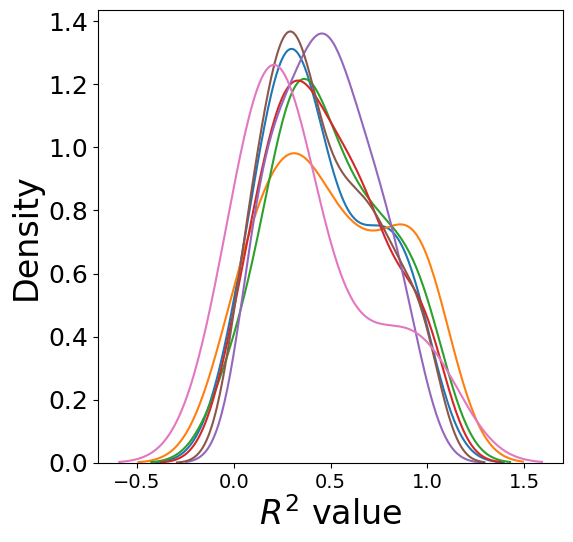

In [20]:
plt.figure(figsize=(6, 6), dpi=100)
all_conditions = ["preterm", "gestationalDM", "preeclampsia", "gestationalHTN", "postpartumHemorrhage", "depression", "superHealthy"]
p_value_all = []
# Loop over each condition and plot the KDE for the r2_value where the condition is 1
for condition in all_conditions:
    positive_condition = pregnancy_conditions_analysis[pregnancy_conditions_analysis[condition] == 1]
    negative_condition = pregnancy_conditions_analysis[pregnancy_conditions_analysis[condition] == 0]
    sns.kdeplot(positive_condition['r2_value'], fill=False, label=condition)
    # Perform independent two-sample t-test
    t_stat, p_value = stats.ttest_ind(positive_condition["r2_value"], negative_condition["r2_value"])
    p_value_all.append(p_value)
# plt.title('Kernel Density Plot for r2_value across Conditions')
plt.xlabel('$R^2$ value', fontsize=24)
plt.ylabel('Density', fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=18)
# plt.legend(fontsize=14)
plt.show()

Text(0, 0.5, 'p value')

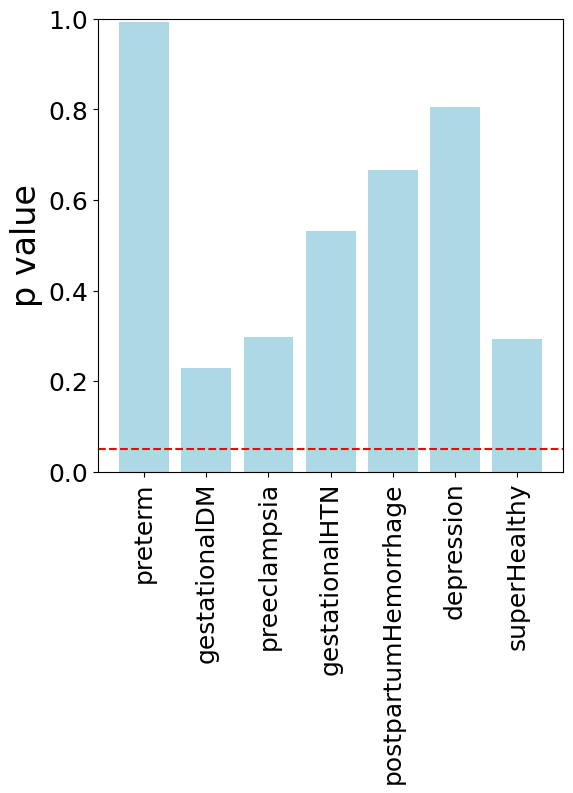

In [21]:
# Plotting the vertical bar graph
plt.figure(figsize=(6, 6), dpi=100)
plt.bar(all_conditions, p_value_all, color='lightblue')

plt.ylim([0, 1])
# Adding title and labels
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
# plt.xlabel('conditions')
plt.axhline(0.05, color='red', linestyle='--')
plt.ylabel('p value', fontsize=24)

## HRV condition analysis

In [22]:
hrv_data = pd.read_csv("hrv_best_fits.csv")

In [23]:
pregnancy_conditions_analysis = pd.merge(hrv_data, pregnancy_conditions, on='record_id', how='inner')  # 'how' can be 'inner', 'left', 'right', or 'outer'

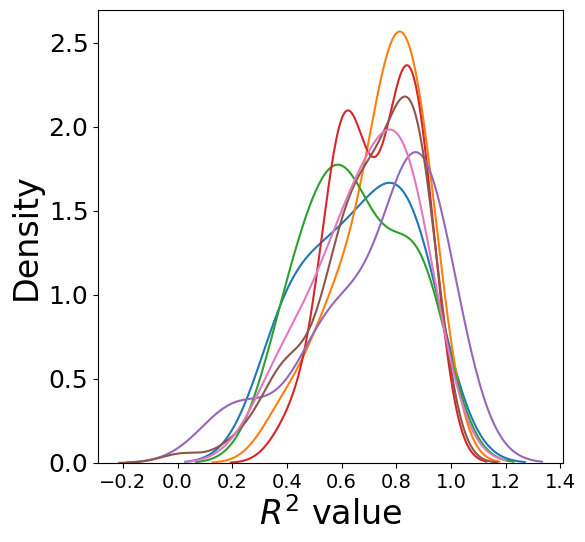

In [24]:
plt.figure(figsize=(6, 6), dpi=100)
all_conditions = ["preterm", "gestationalDM", "preeclampsia", "gestationalHTN", "postpartumHemorrhage", "depression", "superHealthy"]
p_value_all = []
# Loop over each condition and plot the KDE for the r2_value where the condition is 1
for condition in all_conditions:
    positive_condition = pregnancy_conditions_analysis[pregnancy_conditions_analysis[condition] == 1]
    negative_condition = pregnancy_conditions_analysis[pregnancy_conditions_analysis[condition] == 0]
    sns.kdeplot(positive_condition['r2_value'], fill=False, label=condition)
    # Perform independent two-sample t-test
    t_stat, p_value = stats.ttest_ind(positive_condition["r2_value"], negative_condition["r2_value"])
    p_value_all.append(p_value)
# plt.title('Kernel Density Plot for r2_value across Conditions')
plt.xlabel('$R^2$ value', fontsize=24)
plt.ylabel('Density', fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=18)
# plt.legend(fontsize=14)
plt.show()

Text(0, 0.5, 'p value')

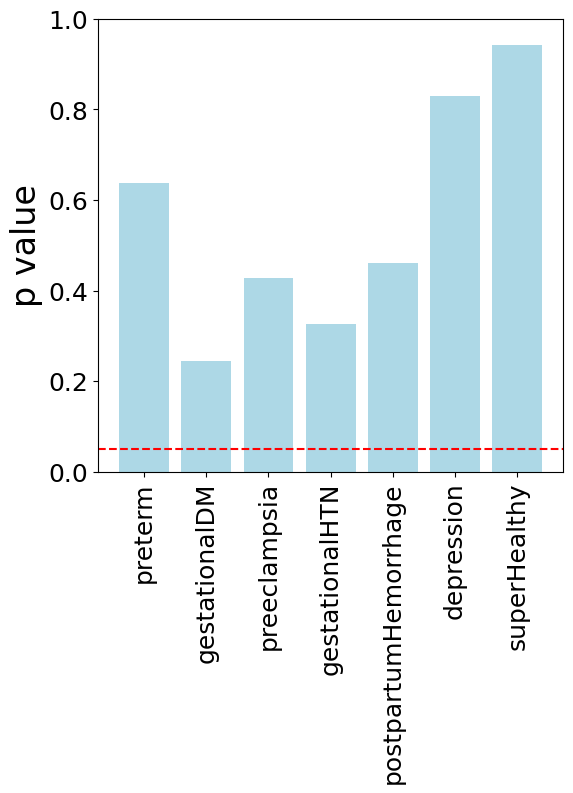

In [25]:
# Plotting the vertical bar graph
plt.figure(figsize=(6, 6), dpi=100)
plt.bar(all_conditions, p_value_all, color='lightblue')

plt.ylim([0, 1])
# Adding title and labels
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
# plt.xlabel('conditions')
plt.axhline(0.05, color='red', linestyle='--')
plt.ylabel('p value', fontsize=24)

## Deep sleep condition analysis

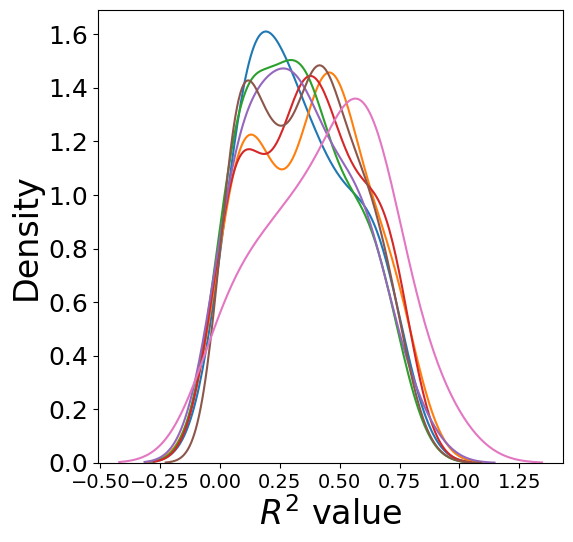

In [26]:
deep_sleep_data = pd.read_csv("r2_deep.csv")
pregnancy_conditions_analysis = pd.merge(deep_sleep_data, pregnancy_conditions, on='record_id', how='inner')  # 'how' can be 'inner', 'left', 'right', or 'outer'
plt.figure(figsize=(6, 6), dpi=100)
all_conditions = ["preterm", "gestationalDM", "preeclampsia", "gestationalHTN", "postpartumHemorrhage", "depression", "superHealthy"]
p_value_all = []
# Loop over each condition and plot the KDE for the r2_value where the condition is 1
for condition in all_conditions:
    positive_condition = pregnancy_conditions_analysis[pregnancy_conditions_analysis[condition] == 1]
    negative_condition = pregnancy_conditions_analysis[pregnancy_conditions_analysis[condition] == 0]
    sns.kdeplot(positive_condition['r2_value'], fill=False, label=condition)
    # Perform independent two-sample t-test
    t_stat, p_value = stats.ttest_ind(positive_condition["r2_value"], negative_condition["r2_value"])
    p_value_all.append(p_value)
# plt.title('Kernel Density Plot for r2_value across Conditions')
plt.xlabel('$R^2$ value', fontsize=24)
plt.ylabel('Density', fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=18)
# plt.legend(fontsize=14)
plt.show()

Text(0, 0.5, 'p value')

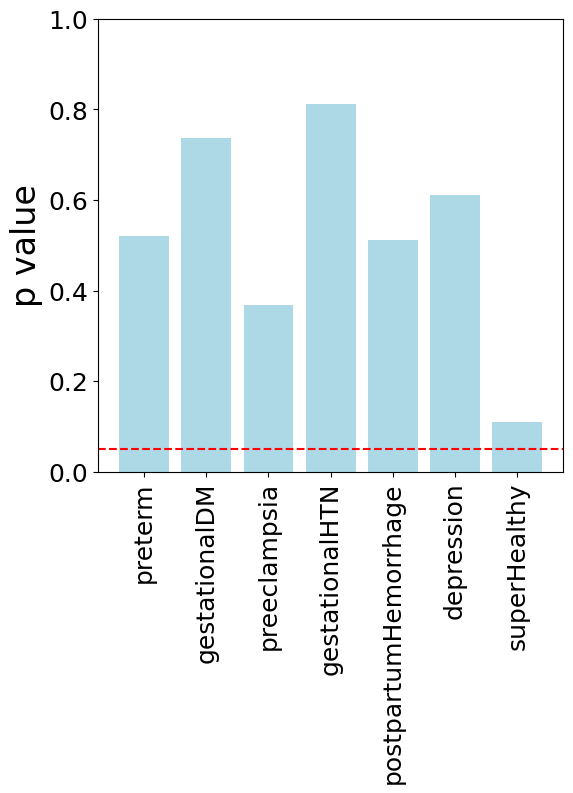

In [27]:
# Plotting the vertical bar graph
plt.figure(figsize=(6, 6), dpi=100)
plt.bar(all_conditions, p_value_all, color='lightblue')

plt.ylim([0, 1])
# Adding title and labels
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
# plt.xlabel('conditions')
plt.axhline(0.05, color='red', linestyle='--')
plt.ylabel('p value', fontsize=24)

## Awake time condition analysis

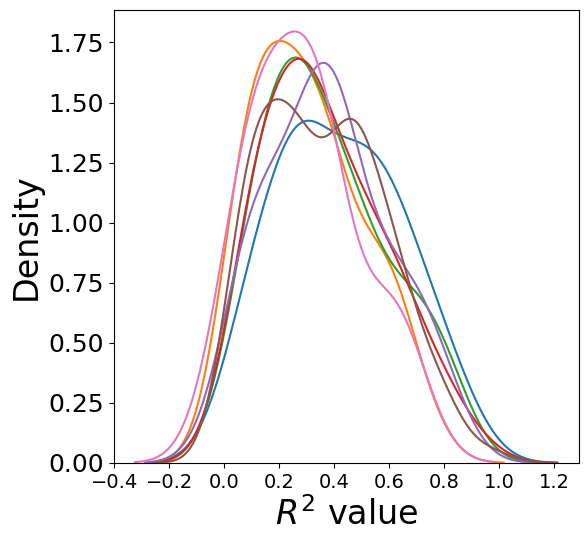

In [28]:
awake_data = pd.read_csv("r2_awake.csv")
pregnancy_conditions_analysis = pd.merge(awake_data, pregnancy_conditions, on='record_id', how='inner')  # 'how' can be 'inner', 'left', 'right', or 'outer'
plt.figure(figsize=(6, 6), dpi=100)
all_conditions = ["preterm", "gestationalDM", "preeclampsia", "gestationalHTN", "postpartumHemorrhage", "depression", "superHealthy"]
p_value_all = []
# Loop over each condition and plot the KDE for the r2_value where the condition is 1
for condition in all_conditions:
    positive_condition = pregnancy_conditions_analysis[pregnancy_conditions_analysis[condition] == 1]
    negative_condition = pregnancy_conditions_analysis[pregnancy_conditions_analysis[condition] == 0]
    sns.kdeplot(positive_condition['r2_value'], fill=False, label=condition)
    # Perform independent two-sample t-test
    t_stat, p_value = stats.ttest_ind(positive_condition["r2_value"], negative_condition["r2_value"])
    p_value_all.append(p_value)
# plt.title('Kernel Density Plot for r2_value across Conditions')
plt.xlabel('$R^2$ value', fontsize=24)
plt.ylabel('Density', fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=18)
# plt.legend(fontsize=14)
plt.show()

Text(0, 0.5, 'p value')

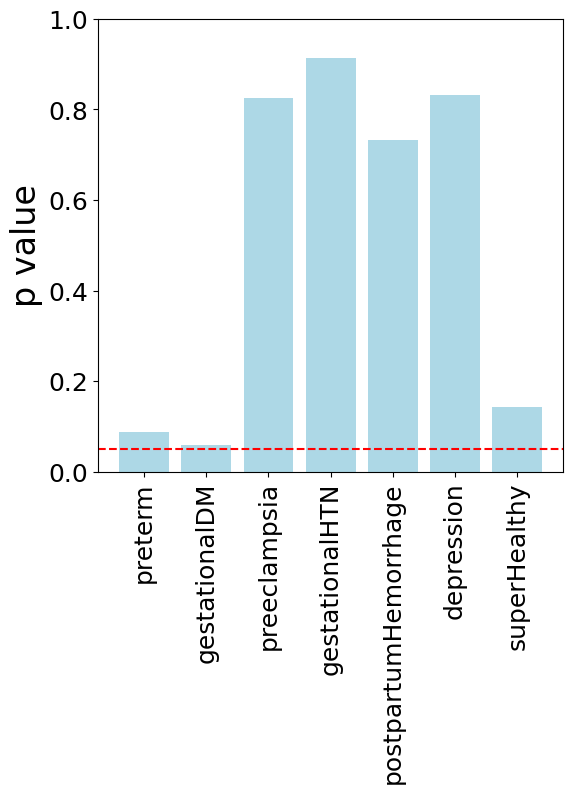

In [29]:
# Plotting the vertical bar graph
plt.figure(figsize=(6, 6), dpi=100)
plt.bar(all_conditions, p_value_all, color='lightblue')

plt.ylim([0, 1])
# Adding title and labels
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
# plt.xlabel('conditions')
plt.axhline(0.05, color='red', linestyle='--')
plt.ylabel('p value', fontsize=24)

## Age, bmi, prev birth for HRV

In [30]:
from sklearn.linear_model import LinearRegression
def load_static_feat(file_loc, ids_list, df_birth, impute=True, parity=True, pred_cond=True):
    key = 'bump/app_activities/surveys.csv.gz'
    df_survey = pd.read_csv(file_loc+key, compression='gzip') #dtype={"user_id": int, "username": "string"}
    df_survey_new = df_survey.loc[df_survey.record_id.isin(ids_list)]
    
    if parity:
        n_prev_baby = df_survey_new.loc[:,['record_id','answer_text']].loc[df_survey_new.question_id==264]
        n_prev_baby.drop_duplicates(inplace=True)
        n_prev_baby = n_prev_baby.iloc[:-2]
        n_prev_baby['n_prev_baby'] = pd.to_numeric(n_prev_baby['answer_text'])
        n_prev_baby.drop(columns=['answer_text'], inplace=True)

    age = df_survey_new.loc[:,['record_id','question_text','answer_text']].loc[df_survey_new.question_id==167]
    age['answer_text'] = pd.to_datetime(age.answer_text).dt.date
    age.drop_duplicates(inplace=True)
    age = age.groupby("record_id").agg(min_date=('answer_text', 'min'))
    df_birth2 = df_birth.drop_duplicates(subset=['record_id']) 
    age = age.merge(df_birth2.loc[:,['birth_date','record_id','birth_gestage']], how='left', on='record_id')
    age['birth_date'] = pd.to_datetime(age.birth_date).dt.date
    age['gestage_week'] = age['birth_gestage'].str.split("w|,| ", n=1).str[0]
    age['gestage_week'] = age['gestage_week'].str.replace(">", '')
    #age['gestage_week'].loc[age['gestage_week'].str.contains('\\+', na=False)] = np.nan
    age['gestage_week'] = age['gestage_week'].str.replace("+", '')
    age = age.dropna(subset=['birth_gestage'])
    age['gestage_week'] = pd.to_numeric(age['gestage_week'])
    age['age'] = (age.birth_date-age.min_date)/ np.timedelta64(1, 'W')#.astype(int)
    age['age'] = (age['age'] - age['gestage_week'])//(4*12)
    age.drop(columns=['birth_gestage','birth_date','min_date'], inplace=True)
    if pred_cond:
        prev_condition_q = df_survey_new.question_text.loc[df_survey.question_text.str.contains('condition')].unique()
        for i in range(len(prev_condition_q)):
            df = df_survey_new.loc[:,['record_id','answer_text', 'question_id','id']].loc[df_survey_new.question_text==(prev_condition_q[i])].copy()
            df.drop_duplicates(inplace=True)
            df = df.loc[df.groupby('record_id').id.idxmin()].reset_index(drop=True)
            df.rename(columns={"answer_text": str(df.question_id.iloc[1])},inplace=True)
            df.drop(['question_id','id'], axis=1, inplace=True)
            if(i==0):
                prev_cond = df
            else:
                prev_cond = prev_cond.merge(df,how='right',on='record_id')
        prev_cond = prev_cond.replace(['No','Yes','Not sure'],[0,1,0.5])
        prev_cond = prev_cond.drop(columns=['233', '235', '237','238','247','249', '258', '259']) #Heart Disease: 3, Kidney Disease: 3

    key = 'bump/redcap/personal_characteristics.csv.gz'
    df_personal = pd.read_csv(file_loc+key, compression='gzip')
    df_personal_new = df_personal.loc[df_personal.record_id.isin(ids_list)].copy()
    df_weight = df_personal_new.loc[:,['weight_prepreg','weight','record_id']].drop_duplicates()
    lin_model = LinearRegression()
    loc_id = (df_weight['weight']=='134  (124 before ivf)')
    df_weight.loc[loc_id, ['weight_prepreg', 'weight']] = ['124', '134']
    df_weight.weight.loc[df_weight.weight=='UNKNOWN'] = np.nan
    df_weight['weight'] = pd.to_numeric(df_weight['weight'])
    df_weight['weight_pre'] = df_weight.weight_prepreg.str.split("-| ", n=1).str[0]
    df_weight['weight_pre'] = pd.to_numeric(df_weight['weight_pre'])
    df_weight = df_weight.sort_values(by='weight')
    df2 = df_weight.dropna().copy()
    x = np.array(df2.weight.values).reshape(-1,1)
    y = np.array(df2.weight_pre.values).reshape(-1)
    lin_model.fit(x, y)
    df_weight = df_weight.loc[df_weight.weight.notna()]
    pre_loc = df_weight.weight_pre.isna()
    df_weight.weight_pre.loc[pre_loc] = list(lin_model.intercept_ + lin_model.coef_ * df_weight.weight.loc[pre_loc])
    df_weight.drop(columns=['weight_prepreg','weight'], inplace=True)
    
    df_height = df_personal_new.loc[:,['height_feet','height_inches','record_id']].copy().drop_duplicates()
    loc_id = (df_height['height_feet']=='5 feet 7 inches')
    df_height.loc[loc_id, ['height_feet', 'height_inches']] = ['5', 7]
    df_height.height_inches.fillna(0, inplace=True)
    df_height.loc[df_height.height_inches>=12, ['height_inches']] = 6
    df_height['height_feet'] = df_height.height_feet.str.split("\'", n=1).str[0]
    df_height['height_feet'] = df_height.height_feet.str.split("\.", n=1).str[0]
    df_height['height_feet'] = pd.to_numeric(df_height['height_feet'])
    df_height = df_height.merge(df_weight,how='inner',on='record_id')
    df_height['bmi'] = calculate_bmi(df_height.weight_pre.values, df_height.height_feet.values, df_height.height_inches.values)

    static_feat = age.copy()
    if pred_cond:
        static_feat = static_feat.merge(prev_cond,how='left',on='record_id')
    static_feat = static_feat.merge(df_weight,how='left',on='record_id')
    static_feat = static_feat.merge(df_height[['record_id', 'bmi']],how='left',on='record_id')
    if parity:
        static_feat = static_feat.merge(n_prev_baby,how='left',on='record_id')
    if impute:
        if parity:
            static_feat.n_prev_baby.fillna(0, inplace=True)
        static_feat.weight_pre.fillna(static_feat.weight_pre.mean(), inplace=True)
        static_feat.bmi.fillna(static_feat.bmi.mean(), inplace=True)
        #static_feat = static_feat.loc[static_feat.age.notna()]
        static_feat.fillna(0.0, inplace=True)
    return static_feat
def calculate_bmi(weight_lbs, height_feet, height_inches):
    #In metric units: BMI = weight (kg) ÷ height2 (meters)
    #In US units: BMI = weight (lb) ÷ height2 (inches) * 703

    # Convert height to inches
    total_height_inches = height_feet * 12 + height_inches
    bmi = (weight_lbs / (total_height_inches ** 2)) * 703
    return bmi

In [31]:
demographics_df = load_static_feat('/storage/data/bump/', hrv_data['record_id'].unique(), df_birth, impute=True, parity=True, pred_cond=True)
demographics_df = demographics_df[demographics_df['age'] >= 18]

# Define age groups and add binary columns for each group
demographics_df['Age:25-30'] = ((demographics_df['age'] >= 25) & (demographics_df['age'] < 30)).astype(int)
demographics_df['Age:30-35'] = ((demographics_df['age'] >= 30) & (demographics_df['age'] < 35)).astype(int)
demographics_df['Age:35-40'] = ((demographics_df['age'] >= 35) & (demographics_df['age'] < 40)).astype(int)
demographics_df['Age:40+'] = (demographics_df['age'] >= 40).astype(int)

# Define BMI categories and add binary columns for each category
demographics_df['BMI:<18.5'] = (demographics_df['bmi'] < 18.5).astype(int)
demographics_df['BMI:18.5-25'] = ((demographics_df['bmi'] >= 18.5) & (demographics_df['bmi'] < 25)).astype(int)
demographics_df['BMI:25-30'] = ((demographics_df['bmi'] >= 25) & (demographics_df['bmi'] < 30)).astype(int)
demographics_df['BMI:30-40'] = ((demographics_df['bmi'] >= 30) & (demographics_df['bmi'] < 40)).astype(int)
demographics_df['BMI:40+'] = (demographics_df['bmi'] >= 40).astype(int)

# Define categories for n_prev_baby and add binary columns for each category
demographics_df['Prior Pregnancy:0'] = (demographics_df['n_prev_baby'] == 0).astype(int)
demographics_df['Prior Pregnancy:1'] = (demographics_df['n_prev_baby'] == 1).astype(int)
demographics_df['Prior Pregnancy:2'] = (demographics_df['n_prev_baby'] == 2).astype(int)
demographics_df['Prior Pregnancy:3+'] = (demographics_df['n_prev_baby'] >= 3).astype(int)

age_groups = ["Age:25-30", "Age:30-35", "Age:35-40", "Age:40+"]
bmi_groups = ["BMI:<18.5", "BMI:18.5-25", "BMI:25-30", "BMI:30-40", "BMI:40+"]
prior_pregnancy_groups = ["Prior Pregnancy:0", "Prior Pregnancy:1", "Prior Pregnancy:2", "Prior Pregnancy:3+"]

/tmp/ipykernel_4040/2349990654.py:4: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_survey = pd.read_csv(file_loc+key, compression='gzip') #dtype={"user_id": int, "username": "string"}
/tmp/ipykernel_4040/2349990654.py:42: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  prev_cond = prev_cond.replace(['No','Yes','Not sure'],[0,1,0.5])
/tmp/ipykernel_4040/2349990654.py:52: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermedi

## Age, bmi, prev birth for HRV

age


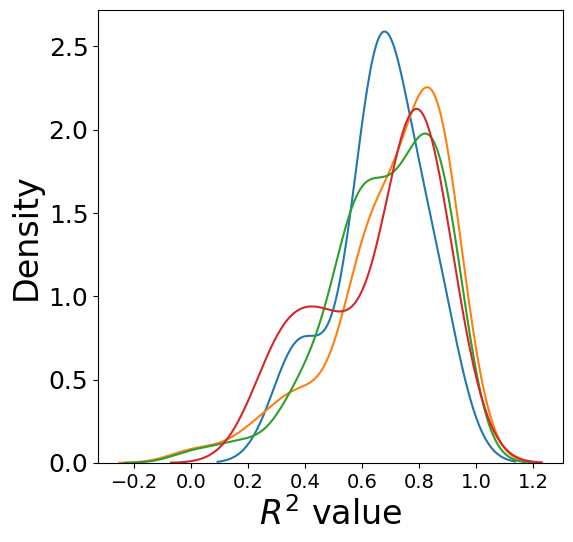

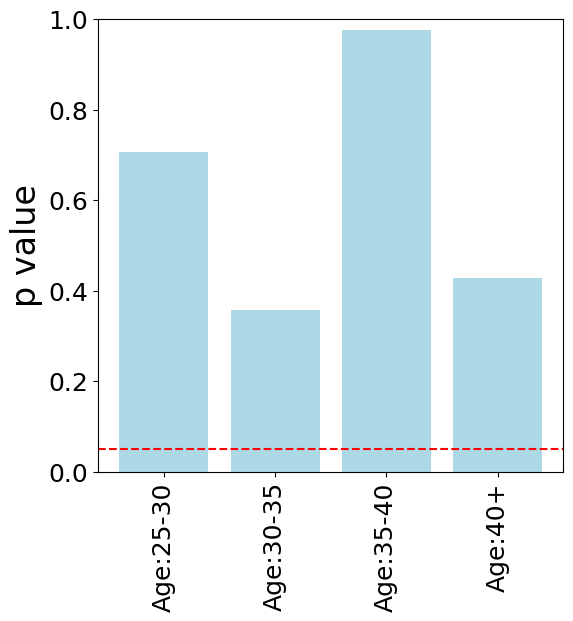

prior pregnancy


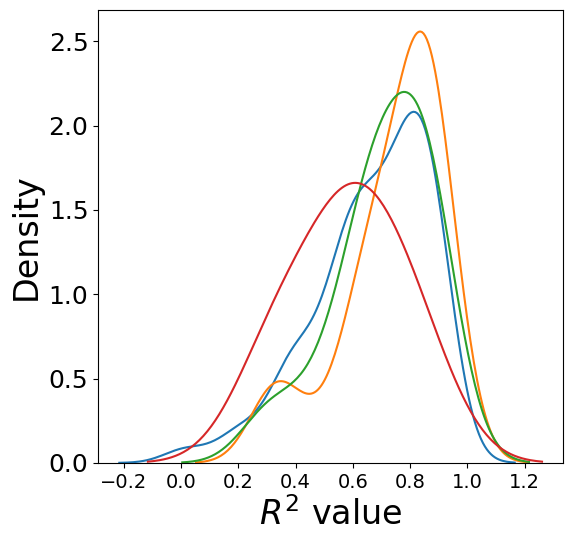

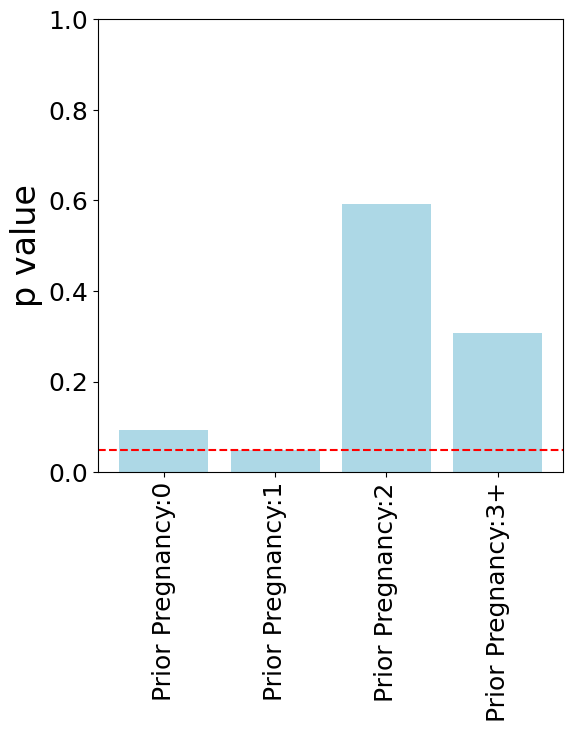

bmi


/tmp/ipykernel_4040/2306075640.py:73: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(positive_condition['r2_value'], fill=False, label=condition)


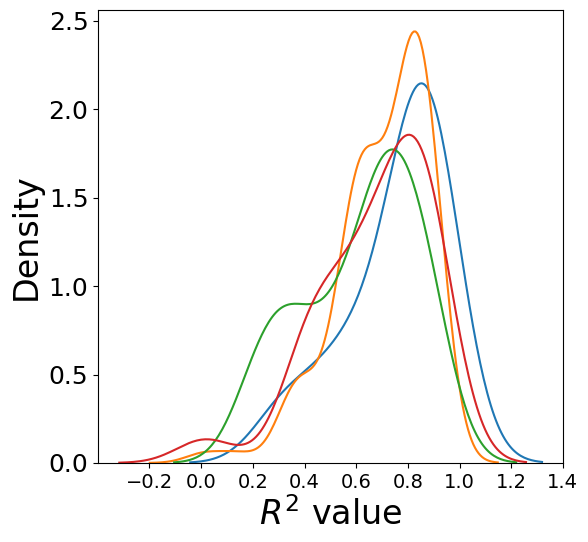

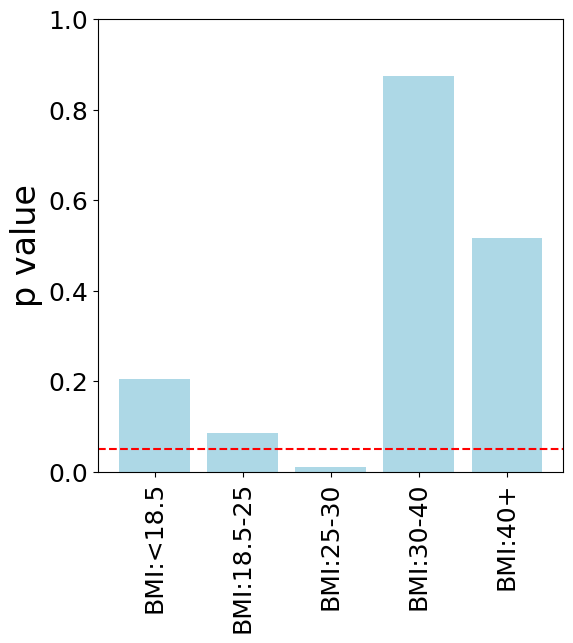

In [32]:
pregnancy_conditions_analysis = pd.merge(hrv_data, demographics_df, on='record_id', how='inner')  # 'how' can be 'inner', 'left', 'right', or 'outer'

plt.figure(figsize=(6, 6), dpi=100)
p_value_all = []
print("age")
# Loop over each condition and plot the KDE for the r2_value where the condition is 1
for condition in age_groups:
    positive_condition = pregnancy_conditions_analysis[pregnancy_conditions_analysis[condition] == 1]
    negative_condition = pregnancy_conditions_analysis[pregnancy_conditions_analysis[condition] == 0]
    sns.kdeplot(positive_condition['r2_value'], fill=False, label=condition)
    # Perform independent two-sample t-test
    t_stat, p_value = stats.ttest_ind(positive_condition["r2_value"], negative_condition["r2_value"])
    p_value_all.append(p_value)
# plt.title('Kernel Density Plot for r2_value across Conditions')
plt.xlabel('$R^2$ value', fontsize=24)
plt.ylabel('Density', fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=18)
# plt.legend(fontsize=14)
plt.show()

# Plotting the vertical bar graph
plt.figure(figsize=(6, 6), dpi=100)
plt.bar(age_groups, p_value_all, color='lightblue')
plt.ylim([0, 1])
# Adding title and labels
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
# plt.xlabel('conditions')
plt.axhline(0.05, color='red', linestyle='--')
plt.ylabel('p value', fontsize=24)
plt.show()

plt.figure(figsize=(6, 6), dpi=100)
p_value_all = []

print("prior pregnancy")
# Loop over each condition and plot the KDE for the r2_value where the condition is 1
for condition in prior_pregnancy_groups:
    positive_condition = pregnancy_conditions_analysis[pregnancy_conditions_analysis[condition] == 1]
    negative_condition = pregnancy_conditions_analysis[pregnancy_conditions_analysis[condition] == 0]
    sns.kdeplot(positive_condition['r2_value'], fill=False, label=condition)
    # Perform independent two-sample t-test
    t_stat, p_value = stats.ttest_ind(positive_condition["r2_value"], negative_condition["r2_value"])
    p_value_all.append(p_value)
# plt.title('Kernel Density Plot for r2_value across Conditions')
plt.xlabel('$R^2$ value', fontsize=24)
plt.ylabel('Density', fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=18)
# plt.legend(fontsize=14)
plt.show()

# Plotting the vertical bar graph
plt.figure(figsize=(6, 6), dpi=100)
plt.bar(prior_pregnancy_groups, p_value_all, color='lightblue')
plt.ylim([0, 1])
# Adding title and labels
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
# plt.xlabel('conditions')
plt.axhline(0.05, color='red', linestyle='--')
plt.ylabel('p value', fontsize=24)
plt.show()

plt.figure(figsize=(6, 6), dpi=100)
p_value_all = []
print("bmi")
# Loop over each condition and plot the KDE for the r2_value where the condition is 1
for condition in bmi_groups:
    positive_condition = pregnancy_conditions_analysis[pregnancy_conditions_analysis[condition] == 1]
    negative_condition = pregnancy_conditions_analysis[pregnancy_conditions_analysis[condition] == 0]
    sns.kdeplot(positive_condition['r2_value'], fill=False, label=condition)
    # Perform independent two-sample t-test
    t_stat, p_value = stats.ttest_ind(positive_condition["r2_value"], negative_condition["r2_value"])
    p_value_all.append(p_value)
# plt.title('Kernel Density Plot for r2_value across Conditions')
plt.xlabel('$R^2$ value', fontsize=24)
plt.ylabel('Density', fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=18)
# plt.legend(fontsize=14)
plt.show()

# Plotting the vertical bar graph
plt.figure(figsize=(6, 6), dpi=100)
plt.bar(bmi_groups, p_value_all, color='lightblue')
plt.ylim([0, 1])
# Adding title and labels
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
# plt.xlabel('conditions')
plt.axhline(0.05, color='red', linestyle='--')
plt.ylabel('p value', fontsize=24)
plt.show()



## Age, bmi, prev birth for Fatigue

In [33]:
demographics_df = load_static_feat('/storage/data/bump/', r2_value_df['record_id'].unique(), df_birth, impute=True, parity=True, pred_cond=True)
demographics_df = demographics_df[demographics_df['age'] >= 18]

# Define age groups and add binary columns for each group
demographics_df['Age:25-30'] = ((demographics_df['age'] >= 25) & (demographics_df['age'] < 30)).astype(int)
demographics_df['Age:30-35'] = ((demographics_df['age'] >= 30) & (demographics_df['age'] < 35)).astype(int)
demographics_df['Age:35-40'] = ((demographics_df['age'] >= 35) & (demographics_df['age'] < 40)).astype(int)
demographics_df['Age:40+'] = (demographics_df['age'] >= 40).astype(int)

# Define BMI categories and add binary columns for each category
demographics_df['BMI:<18.5'] = (demographics_df['bmi'] < 18.5).astype(int)
demographics_df['BMI:18.5-25'] = ((demographics_df['bmi'] >= 18.5) & (demographics_df['bmi'] < 25)).astype(int)
demographics_df['BMI:25-30'] = ((demographics_df['bmi'] >= 25) & (demographics_df['bmi'] < 30)).astype(int)
demographics_df['BMI:30-40'] = ((demographics_df['bmi'] >= 30) & (demographics_df['bmi'] < 40)).astype(int)
demographics_df['BMI:40+'] = (demographics_df['bmi'] >= 40).astype(int)

# Define categories for n_prev_baby and add binary columns for each category
demographics_df['Prior Pregnancy:0'] = (demographics_df['n_prev_baby'] == 0).astype(int)
demographics_df['Prior Pregnancy:1'] = (demographics_df['n_prev_baby'] == 1).astype(int)
demographics_df['Prior Pregnancy:2'] = (demographics_df['n_prev_baby'] == 2).astype(int)
demographics_df['Prior Pregnancy:3+'] = (demographics_df['n_prev_baby'] >= 3).astype(int)

age_groups = ["Age:25-30", "Age:30-35", "Age:35-40", "Age:40+"]
bmi_groups = ["BMI:<18.5", "BMI:18.5-25", "BMI:25-30", "BMI:30-40", "BMI:40+"]
prior_pregnancy_groups = ["Prior Pregnancy:0", "Prior Pregnancy:1", "Prior Pregnancy:2", "Prior Pregnancy:3+"]


/tmp/ipykernel_4040/2349990654.py:4: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_survey = pd.read_csv(file_loc+key, compression='gzip') #dtype={"user_id": int, "username": "string"}
/tmp/ipykernel_4040/2349990654.py:42: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  prev_cond = prev_cond.replace(['No','Yes','Not sure'],[0,1,0.5])
/tmp/ipykernel_4040/2349990654.py:52: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermedi

age


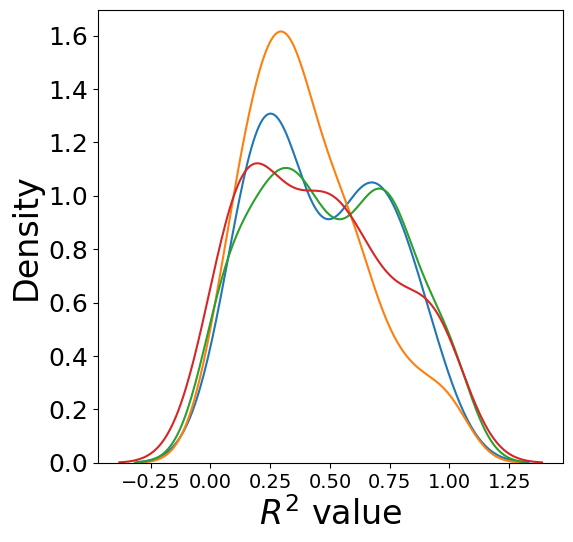

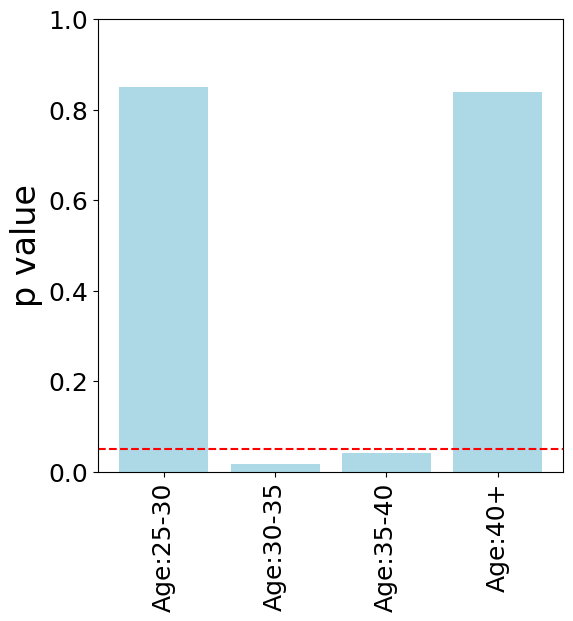

prior pregnancy


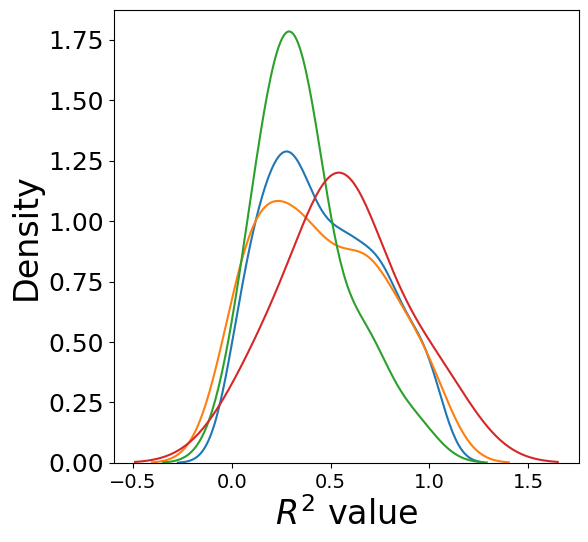

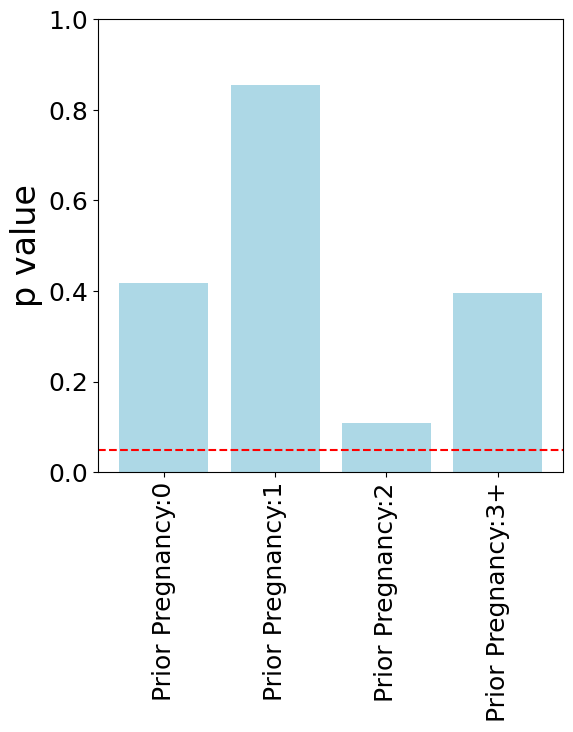

bmi


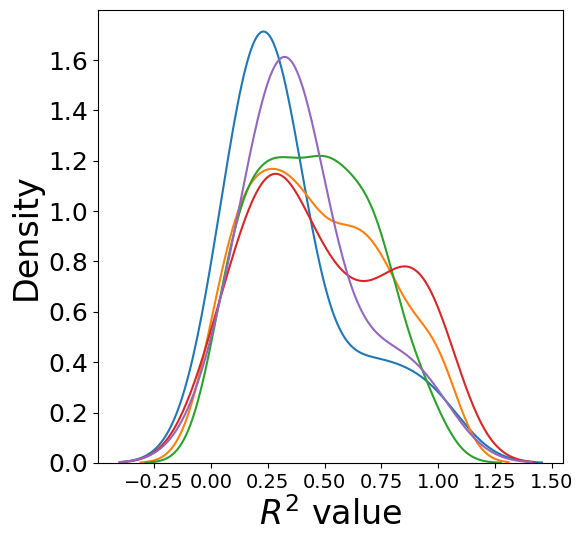

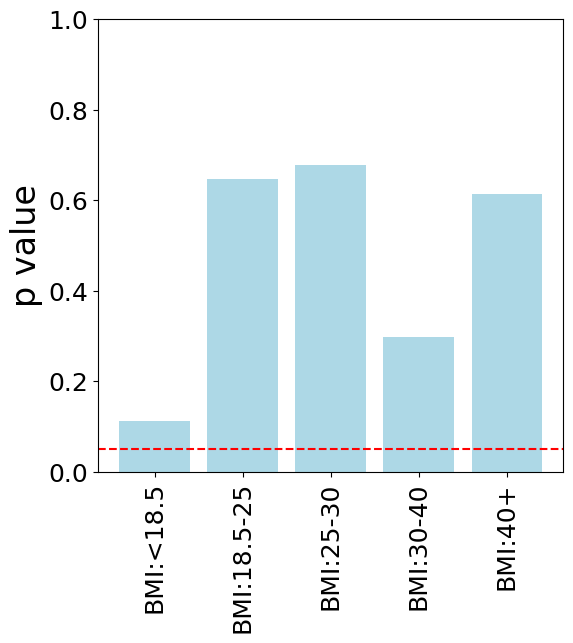

In [34]:
pregnancy_conditions_analysis = pd.merge(r2_value_df, demographics_df, on='record_id', how='inner')  # 'how' can be 'inner', 'left', 'right', or 'outer'

plt.figure(figsize=(6, 6), dpi=100)
p_value_all = []
print("age")
# Loop over each condition and plot the KDE for the r2_value where the condition is 1
for condition in age_groups:
    positive_condition = pregnancy_conditions_analysis[pregnancy_conditions_analysis[condition] == 1]
    negative_condition = pregnancy_conditions_analysis[pregnancy_conditions_analysis[condition] == 0]
    sns.kdeplot(positive_condition['r2_value'], fill=False, label=condition)
    # Perform independent two-sample t-test
    t_stat, p_value = stats.ttest_ind(positive_condition["r2_value"], negative_condition["r2_value"])
    p_value_all.append(p_value)
# plt.title('Kernel Density Plot for r2_value across Conditions')
plt.xlabel('$R^2$ value', fontsize=24)
plt.ylabel('Density', fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=18)
# plt.legend(fontsize=14)
plt.show()

# Plotting the vertical bar graph
plt.figure(figsize=(6, 6), dpi=100)
plt.bar(age_groups, p_value_all, color='lightblue')
plt.ylim([0, 1])
# Adding title and labels
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
# plt.xlabel('conditions')
plt.axhline(0.05, color='red', linestyle='--')
plt.ylabel('p value', fontsize=24)
plt.show()

plt.figure(figsize=(6, 6), dpi=100)
p_value_all = []
print("prior pregnancy")
# Loop over each condition and plot the KDE for the r2_value where the condition is 1
for condition in prior_pregnancy_groups:
    positive_condition = pregnancy_conditions_analysis[pregnancy_conditions_analysis[condition] == 1]
    negative_condition = pregnancy_conditions_analysis[pregnancy_conditions_analysis[condition] == 0]
    sns.kdeplot(positive_condition['r2_value'], fill=False, label=condition)
    # Perform independent two-sample t-test
    t_stat, p_value = stats.ttest_ind(positive_condition["r2_value"], negative_condition["r2_value"])
    p_value_all.append(p_value)
# plt.title('Kernel Density Plot for r2_value across Conditions')
plt.xlabel('$R^2$ value', fontsize=24)
plt.ylabel('Density', fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=18)
# plt.legend(fontsize=14)
plt.show()

# Plotting the vertical bar graph
plt.figure(figsize=(6, 6), dpi=100)
plt.bar(prior_pregnancy_groups, p_value_all, color='lightblue')
plt.ylim([0, 1])
# Adding title and labels
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
# plt.xlabel('conditions')
plt.axhline(0.05, color='red', linestyle='--')
plt.ylabel('p value', fontsize=24)
plt.show()

plt.figure(figsize=(6, 6), dpi=100)
p_value_all = []
print("bmi")
# Loop over each condition and plot the KDE for the r2_value where the condition is 1
for condition in bmi_groups:
    positive_condition = pregnancy_conditions_analysis[pregnancy_conditions_analysis[condition] == 1]
    negative_condition = pregnancy_conditions_analysis[pregnancy_conditions_analysis[condition] == 0]
    sns.kdeplot(positive_condition['r2_value'], fill=False, label=condition)
    # Perform independent two-sample t-test
    t_stat, p_value = stats.ttest_ind(positive_condition["r2_value"], negative_condition["r2_value"])
    p_value_all.append(p_value)
# plt.title('Kernel Density Plot for r2_value across Conditions')
plt.xlabel('$R^2$ value', fontsize=24)
plt.ylabel('Density', fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=18)
# plt.legend(fontsize=14)
plt.show()

# Plotting the vertical bar graph
plt.figure(figsize=(6, 6), dpi=100)
plt.bar(bmi_groups, p_value_all, color='lightblue')
plt.ylim([0, 1])
# Adding title and labels
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
# plt.xlabel('conditions')
plt.axhline(0.05, color='red', linestyle='--')
plt.ylabel('p value', fontsize=24)
plt.show()


## Age, bmi, prev birth for Deep Sleep

In [35]:
demographics_df = load_static_feat('/storage/data/bump/', deep_sleep_data['record_id'].unique(), df_birth, impute=True, parity=True, pred_cond=True)
demographics_df = demographics_df[demographics_df['age'] >= 18]

# Define age groups and add binary columns for each group
demographics_df['Age:25-30'] = ((demographics_df['age'] >= 25) & (demographics_df['age'] < 30)).astype(int)
demographics_df['Age:30-35'] = ((demographics_df['age'] >= 30) & (demographics_df['age'] < 35)).astype(int)
demographics_df['Age:35-40'] = ((demographics_df['age'] >= 35) & (demographics_df['age'] < 40)).astype(int)
demographics_df['Age:40+'] = (demographics_df['age'] >= 40).astype(int)

# Define BMI categories and add binary columns for each category
demographics_df['BMI:<18.5'] = (demographics_df['bmi'] < 18.5).astype(int)
demographics_df['BMI:18.5-25'] = ((demographics_df['bmi'] >= 18.5) & (demographics_df['bmi'] < 25)).astype(int)
demographics_df['BMI:25-30'] = ((demographics_df['bmi'] >= 25) & (demographics_df['bmi'] < 30)).astype(int)
demographics_df['BMI:30-40'] = ((demographics_df['bmi'] >= 30) & (demographics_df['bmi'] < 40)).astype(int)
demographics_df['BMI:40+'] = (demographics_df['bmi'] >= 40).astype(int)

# Define categories for n_prev_baby and add binary columns for each category
demographics_df['Prior Pregnancy:0'] = (demographics_df['n_prev_baby'] == 0).astype(int)
demographics_df['Prior Pregnancy:1'] = (demographics_df['n_prev_baby'] == 1).astype(int)
demographics_df['Prior Pregnancy:2'] = (demographics_df['n_prev_baby'] == 2).astype(int)
demographics_df['Prior Pregnancy:3+'] = (demographics_df['n_prev_baby'] >= 3).astype(int)

age_groups = ["Age:25-30", "Age:30-35", "Age:35-40", "Age:40+"]
bmi_groups = ["BMI:<18.5", "BMI:18.5-25", "BMI:25-30", "BMI:30-40", "BMI:40+"]
prior_pregnancy_groups = ["Prior Pregnancy:0", "Prior Pregnancy:1", "Prior Pregnancy:2", "Prior Pregnancy:3+"]

/tmp/ipykernel_4040/2349990654.py:4: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_survey = pd.read_csv(file_loc+key, compression='gzip') #dtype={"user_id": int, "username": "string"}
/tmp/ipykernel_4040/2349990654.py:42: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  prev_cond = prev_cond.replace(['No','Yes','Not sure'],[0,1,0.5])
/tmp/ipykernel_4040/2349990654.py:52: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermedi

age


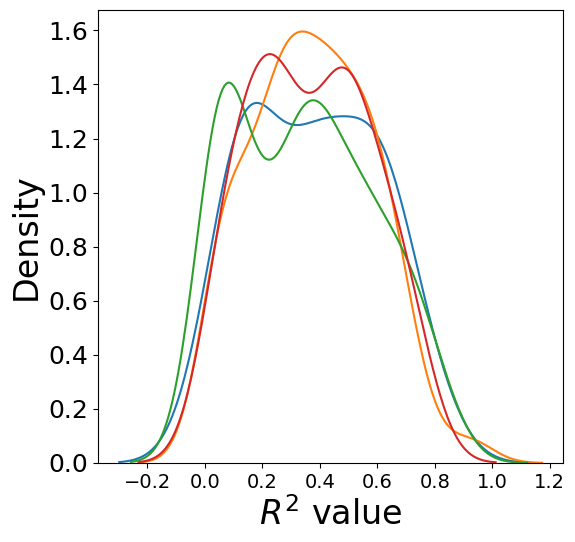

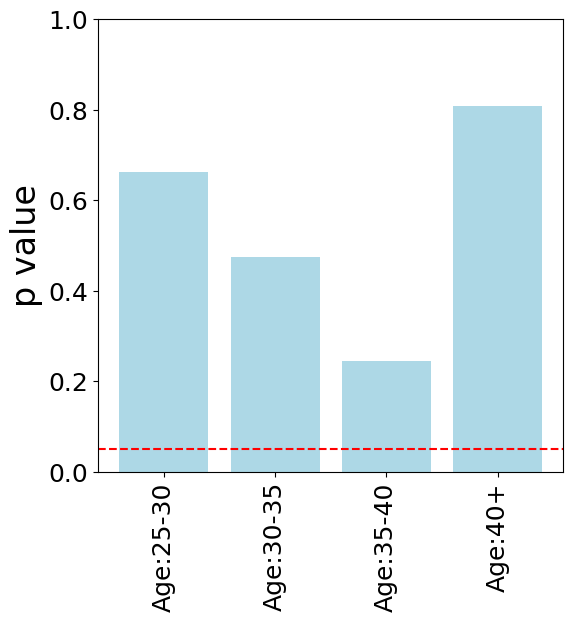

prior pregnancy


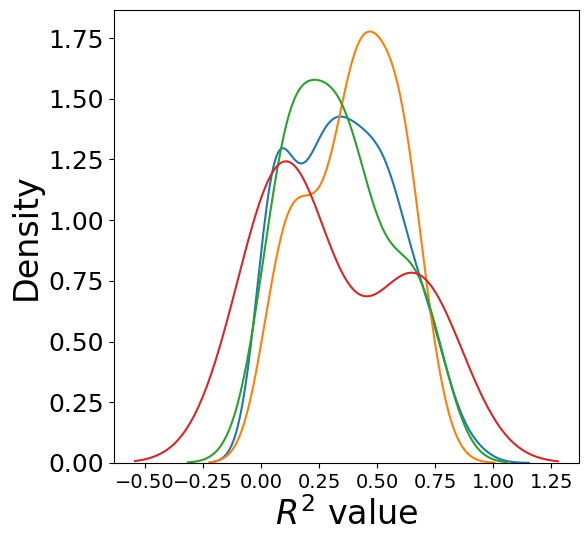

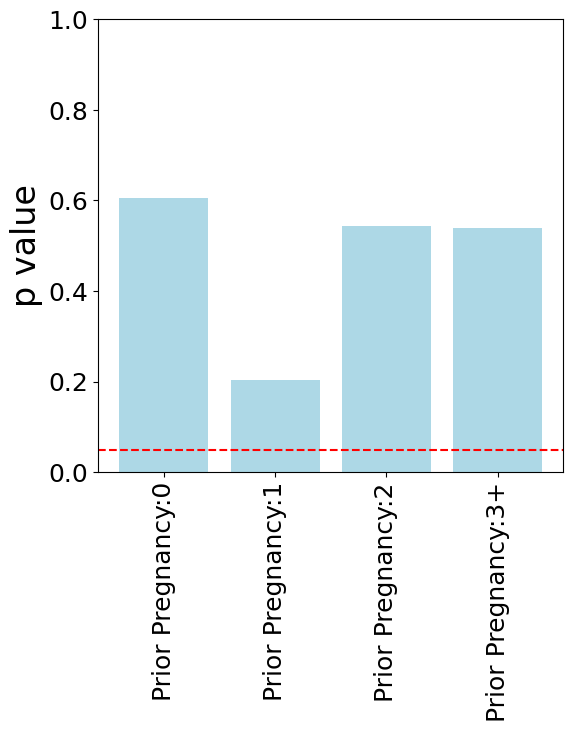

bmi


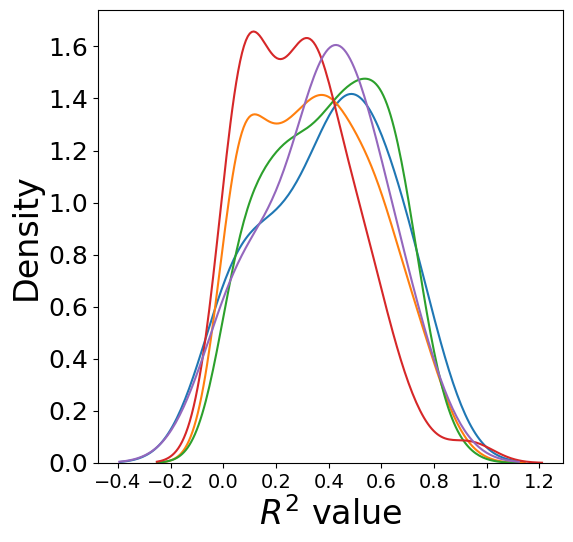

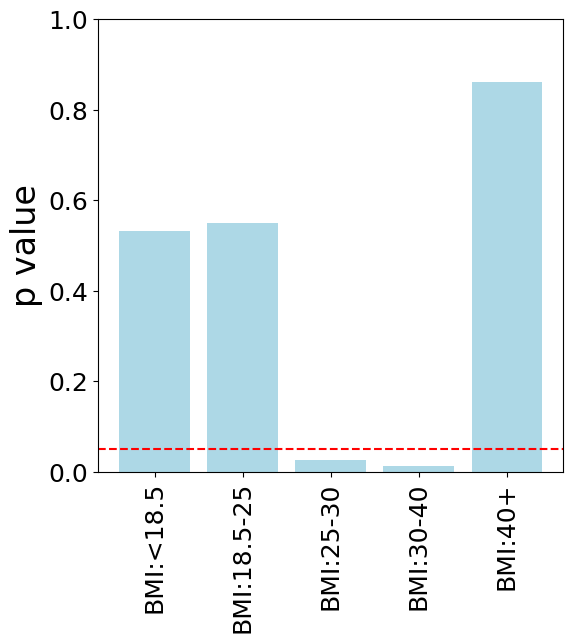

In [36]:
pregnancy_conditions_analysis = pd.merge(deep_sleep_data, demographics_df, on='record_id', how='inner')  # 'how' can be 'inner', 'left', 'right', or 'outer'

plt.figure(figsize=(6, 6), dpi=100)
p_value_all = []
print("age")
# Loop over each condition and plot the KDE for the r2_value where the condition is 1
for condition in age_groups:
    positive_condition = pregnancy_conditions_analysis[pregnancy_conditions_analysis[condition] == 1]
    negative_condition = pregnancy_conditions_analysis[pregnancy_conditions_analysis[condition] == 0]
    sns.kdeplot(positive_condition['r2_value'], fill=False, label=condition)
    # Perform independent two-sample t-test
    t_stat, p_value = stats.ttest_ind(positive_condition["r2_value"], negative_condition["r2_value"])
    p_value_all.append(p_value)
# plt.title('Kernel Density Plot for r2_value across Conditions')
plt.xlabel('$R^2$ value', fontsize=24)
plt.ylabel('Density', fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=18)
# plt.legend(fontsize=14)
plt.show()

# Plotting the vertical bar graph
plt.figure(figsize=(6, 6), dpi=100)
plt.bar(age_groups, p_value_all, color='lightblue')
plt.ylim([0, 1])
# Adding title and labels
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
# plt.xlabel('conditions')
plt.axhline(0.05, color='red', linestyle='--')
plt.ylabel('p value', fontsize=24)
plt.show()

plt.figure(figsize=(6, 6), dpi=100)
p_value_all = []

print("prior pregnancy")
# Loop over each condition and plot the KDE for the r2_value where the condition is 1
for condition in prior_pregnancy_groups:
    positive_condition = pregnancy_conditions_analysis[pregnancy_conditions_analysis[condition] == 1]
    negative_condition = pregnancy_conditions_analysis[pregnancy_conditions_analysis[condition] == 0]
    sns.kdeplot(positive_condition['r2_value'], fill=False, label=condition)
    # Perform independent two-sample t-test
    t_stat, p_value = stats.ttest_ind(positive_condition["r2_value"], negative_condition["r2_value"])
    p_value_all.append(p_value)
# plt.title('Kernel Density Plot for r2_value across Conditions')
plt.xlabel('$R^2$ value', fontsize=24)
plt.ylabel('Density', fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=18)
# plt.legend(fontsize=14)
plt.show()

# Plotting the vertical bar graph
plt.figure(figsize=(6, 6), dpi=100)
plt.bar(prior_pregnancy_groups, p_value_all, color='lightblue')
plt.ylim([0, 1])
# Adding title and labels
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
# plt.xlabel('conditions')
plt.axhline(0.05, color='red', linestyle='--')
plt.ylabel('p value', fontsize=24)
plt.show()

plt.figure(figsize=(6, 6), dpi=100)
p_value_all = []
print("bmi")
# Loop over each condition and plot the KDE for the r2_value where the condition is 1
for condition in bmi_groups:
    positive_condition = pregnancy_conditions_analysis[pregnancy_conditions_analysis[condition] == 1]
    negative_condition = pregnancy_conditions_analysis[pregnancy_conditions_analysis[condition] == 0]
    sns.kdeplot(positive_condition['r2_value'], fill=False, label=condition)
    # Perform independent two-sample t-test
    t_stat, p_value = stats.ttest_ind(positive_condition["r2_value"], negative_condition["r2_value"])
    p_value_all.append(p_value)
# plt.title('Kernel Density Plot for r2_value across Conditions')
plt.xlabel('$R^2$ value', fontsize=24)
plt.ylabel('Density', fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=18)
# plt.legend(fontsize=14)
plt.show()

# Plotting the vertical bar graph
plt.figure(figsize=(6, 6), dpi=100)
plt.bar(bmi_groups, p_value_all, color='lightblue')
plt.ylim([0, 1])
# Adding title and labels
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
# plt.xlabel('conditions')
plt.axhline(0.05, color='red', linestyle='--')
plt.ylabel('p value', fontsize=24)
plt.show()



## Age, bmi, prev birth for Awake Time

In [37]:
demographics_df = load_static_feat('/storage/data/bump/', awake_data['record_id'].unique(), df_birth, impute=True, parity=True, pred_cond=True)
demographics_df = demographics_df[demographics_df['age'] >= 18]

# Define age groups and add binary columns for each group
demographics_df['Age:25-30'] = ((demographics_df['age'] >= 25) & (demographics_df['age'] < 30)).astype(int)
demographics_df['Age:30-35'] = ((demographics_df['age'] >= 30) & (demographics_df['age'] < 35)).astype(int)
demographics_df['Age:35-40'] = ((demographics_df['age'] >= 35) & (demographics_df['age'] < 40)).astype(int)
demographics_df['Age:40+'] = (demographics_df['age'] >= 40).astype(int)

# Define BMI categories and add binary columns for each category
demographics_df['BMI:<18.5'] = (demographics_df['bmi'] < 18.5).astype(int)
demographics_df['BMI:18.5-25'] = ((demographics_df['bmi'] >= 18.5) & (demographics_df['bmi'] < 25)).astype(int)
demographics_df['BMI:25-30'] = ((demographics_df['bmi'] >= 25) & (demographics_df['bmi'] < 30)).astype(int)
demographics_df['BMI:30-40'] = ((demographics_df['bmi'] >= 30) & (demographics_df['bmi'] < 40)).astype(int)
demographics_df['BMI:40+'] = (demographics_df['bmi'] >= 40).astype(int)

# Define categories for n_prev_baby and add binary columns for each category
demographics_df['Prior Pregnancy:0'] = (demographics_df['n_prev_baby'] == 0).astype(int)
demographics_df['Prior Pregnancy:1'] = (demographics_df['n_prev_baby'] == 1).astype(int)
demographics_df['Prior Pregnancy:2'] = (demographics_df['n_prev_baby'] == 2).astype(int)
demographics_df['Prior Pregnancy:3+'] = (demographics_df['n_prev_baby'] >= 3).astype(int)

age_groups = ["Age:25-30", "Age:30-35", "Age:35-40", "Age:40+"]
bmi_groups = ["BMI:<18.5", "BMI:18.5-25", "BMI:25-30", "BMI:30-40", "BMI:40+"]
prior_pregnancy_groups = ["Prior Pregnancy:0", "Prior Pregnancy:1", "Prior Pregnancy:2", "Prior Pregnancy:3+"]

/tmp/ipykernel_4040/2349990654.py:4: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_survey = pd.read_csv(file_loc+key, compression='gzip') #dtype={"user_id": int, "username": "string"}
/tmp/ipykernel_4040/2349990654.py:42: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  prev_cond = prev_cond.replace(['No','Yes','Not sure'],[0,1,0.5])
/tmp/ipykernel_4040/2349990654.py:52: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermedi

age


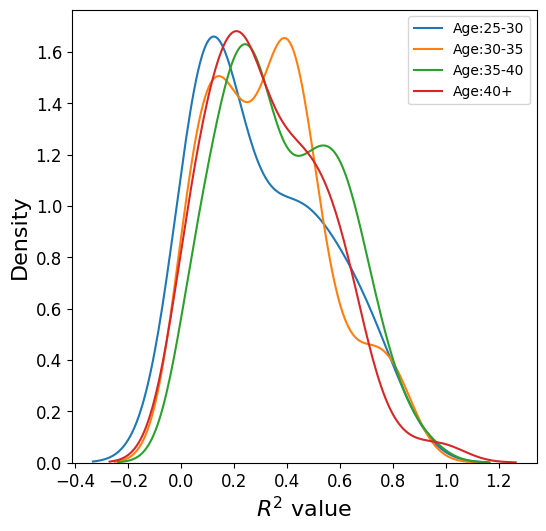

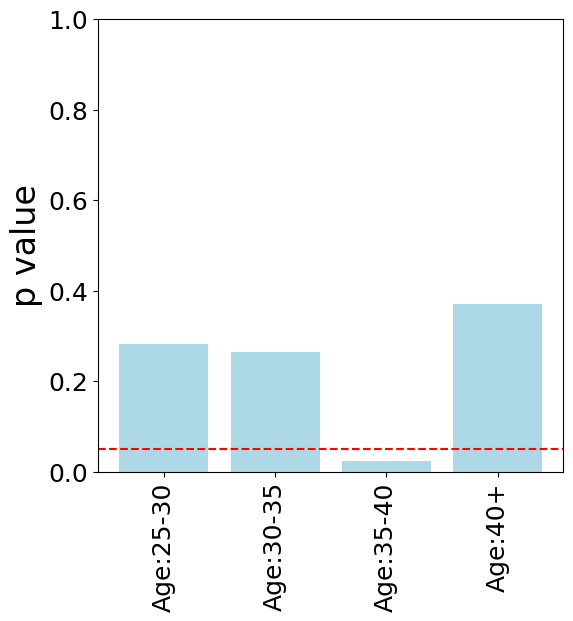

prior pregnancy


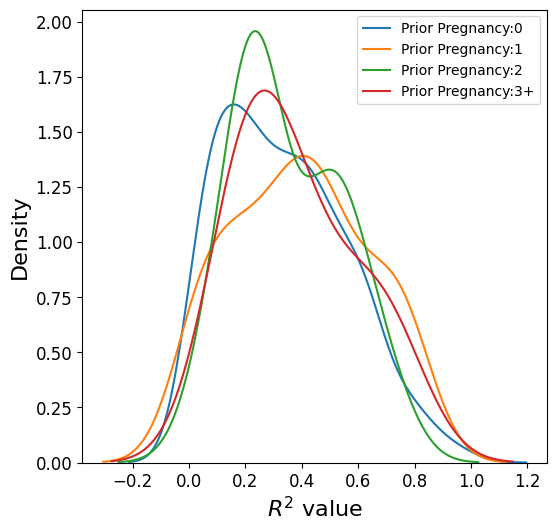

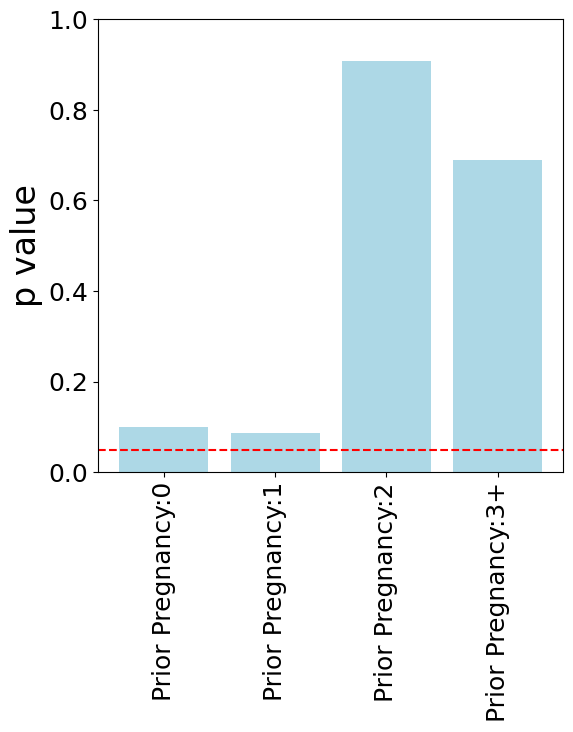

bmi


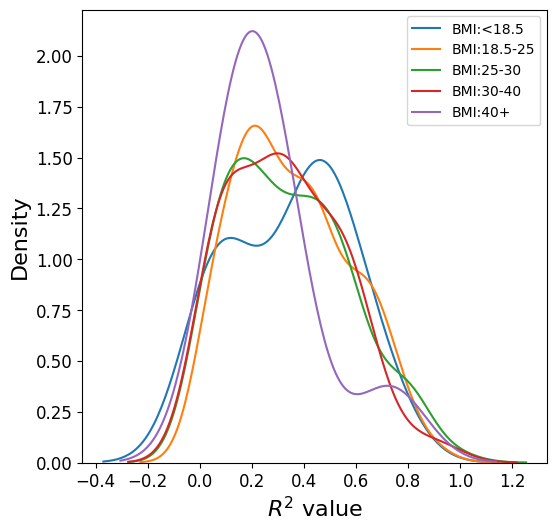

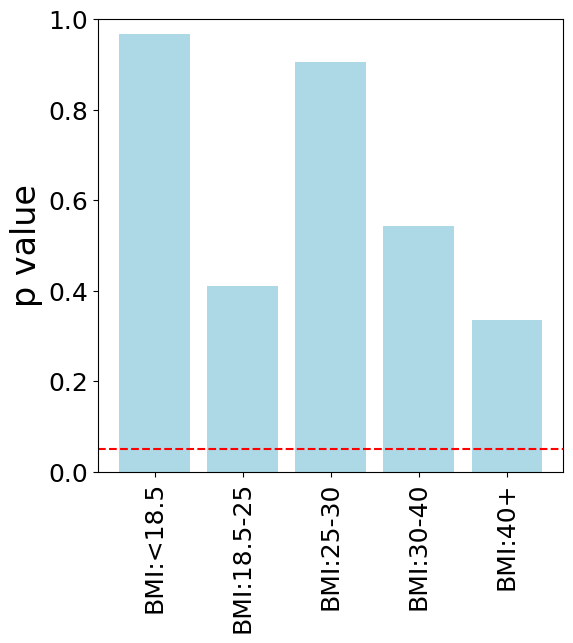

In [39]:
pregnancy_conditions_analysis = pd.merge(awake_data, demographics_df, on='record_id', how='inner')  # 'how' can be 'inner', 'left', 'right', or 'outer'

plt.figure(figsize=(6, 6), dpi=100)
p_value_all = []
print("age")
# Loop over each condition and plot the KDE for the r2_value where the condition is 1
for condition in age_groups:
    positive_condition = pregnancy_conditions_analysis[pregnancy_conditions_analysis[condition] == 1]
    negative_condition = pregnancy_conditions_analysis[pregnancy_conditions_analysis[condition] == 0]
    sns.kdeplot(positive_condition['r2_value'], fill=False, label=condition)
    # Perform independent two-sample t-test
    t_stat, p_value = stats.ttest_ind(positive_condition["r2_value"], negative_condition["r2_value"])
    p_value_all.append(p_value)
# plt.title('Kernel Density Plot for r2_value across Conditions')
plt.xlabel('$R^2$ value', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.show()

# Plotting the vertical bar graph
plt.figure(figsize=(6, 6), dpi=100)
plt.bar(age_groups, p_value_all, color='lightblue')
plt.ylim([0, 1])
# Adding title and labels
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
# plt.xlabel('conditions')
plt.axhline(0.05, color='red', linestyle='--')
plt.ylabel('p value', fontsize=24)
plt.show()

plt.figure(figsize=(6, 6), dpi=100)
p_value_all = []

print("prior pregnancy")
# Loop over each condition and plot the KDE for the r2_value where the condition is 1
for condition in prior_pregnancy_groups:
    positive_condition = pregnancy_conditions_analysis[pregnancy_conditions_analysis[condition] == 1]
    negative_condition = pregnancy_conditions_analysis[pregnancy_conditions_analysis[condition] == 0]
    sns.kdeplot(positive_condition['r2_value'], fill=False, label=condition)
    # Perform independent two-sample t-test
    t_stat, p_value = stats.ttest_ind(positive_condition["r2_value"], negative_condition["r2_value"])
    p_value_all.append(p_value)
# plt.title('Kernel Density Plot for r2_value across Conditions')
plt.xlabel('$R^2$ value', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.show()

# Plotting the vertical bar graph
plt.figure(figsize=(6, 6), dpi=100)
plt.bar(prior_pregnancy_groups, p_value_all, color='lightblue')
plt.ylim([0, 1])
# Adding title and labels
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
# plt.xlabel('conditions')
plt.axhline(0.05, color='red', linestyle='--')
plt.ylabel('p value', fontsize=24)
plt.show()

plt.figure(figsize=(6, 6), dpi=100)
p_value_all = []
print("bmi")
# Loop over each condition and plot the KDE for the r2_value where the condition is 1
for condition in bmi_groups:
    positive_condition = pregnancy_conditions_analysis[pregnancy_conditions_analysis[condition] == 1]
    negative_condition = pregnancy_conditions_analysis[pregnancy_conditions_analysis[condition] == 0]
    sns.kdeplot(positive_condition['r2_value'], fill=False, label=condition)
    # Perform independent two-sample t-test
    t_stat, p_value = stats.ttest_ind(positive_condition["r2_value"], negative_condition["r2_value"])
    p_value_all.append(p_value)
# plt.title('Kernel Density Plot for r2_value across Conditions')
plt.xlabel('$R^2$ value', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.show()

# Plotting the vertical bar graph
plt.figure(figsize=(6, 6), dpi=100)
plt.bar(bmi_groups, p_value_all, color='lightblue')
plt.ylim([0, 1])
# Adding title and labels
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
# plt.xlabel('conditions')
plt.axhline(0.05, color='red', linestyle='--')
plt.ylabel('p value', fontsize=24)
plt.show()

